# xor model visualization

In [1]:
import os, scipy.io 
import numpy as np 
# %matplotlib ipympl
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d

### load model

In [2]:
model_dir = '/home/nuttidalab/Documents/spikeRNN/models/xor/P_rec_0.2_Taus_4.0_20.0'
model_fname = 'Task_xor_N_200_Taus_4.0_20.0_Act_sigmoid_2024_09_25_124903.mat'
mat_data = scipy.io.loadmat(os.path.join(model_dir, model_fname))

In [3]:
for keys in mat_data.keys():
    print(keys)

__header__
__version__
__globals__
x0
r0
w0
taus_gaus0
w_in0
u
o
w
x
target
w_out
r
m
som_m
N
exc
inh
w_in
b_out
som_N
losses
taus
eval_perf_mean
eval_loss_mean
eval_os
eval_labels
taus_gaus
tr
activation


In [4]:
mat_data['tr']

array([[10201]])

(2, 300)


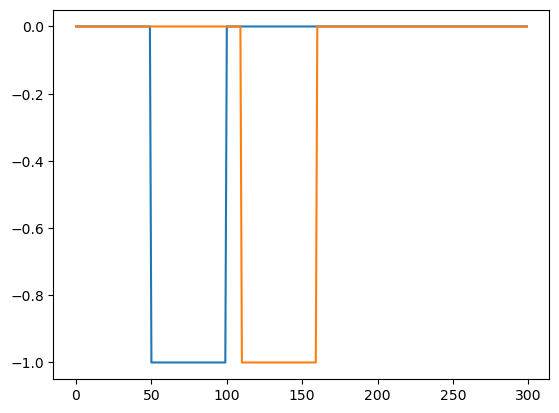

In [7]:
print(mat_data['u'].shape)
plt.plot(mat_data['u'].T)
plt.show()

### Visualize outputs

In [4]:
mat_data['eval_os'].shape

(100, 299)

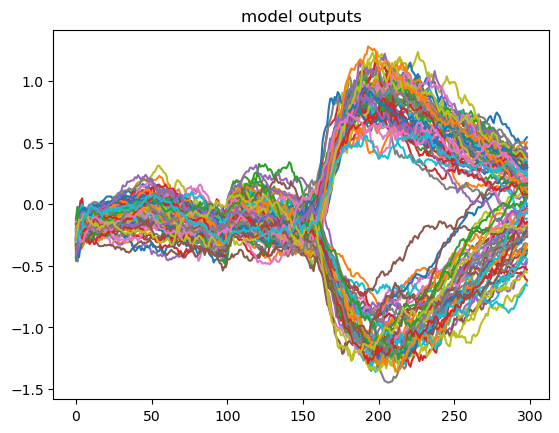

In [6]:
plt.figure()
plt.plot(np.transpose(mat_data['eval_os'][:,]))
plt.title('model outputs')
plt.show()

### get final variables

In [8]:
w = mat_data['w']
m = mat_data['m']
final_w = np.matmul(w, m)
taus_gaus = mat_data['taus_gaus']
taus = mat_data['taus'].flatten()
taus_sig = (1/(1+np.exp(-taus_gaus))*(taus[1] - taus[0])) + taus[0]

In [9]:
exc = mat_data['exc']
exc_ind = np.where(exc == 1)[0]
inh = mat_data['inh']
inh_ind = np.where(inh == 1)[0]
print(inh_ind)

[  4   9  11  23  29  36  45  51  53  56  57  65  72  75  80  91  92  95
 103 107 113 115 116 127 129 131 135 136 153 156 157 161 166 170 173 177
 178 182 186 187 196 199]


### model eval

In [27]:
from model import generate_input_stim_xor

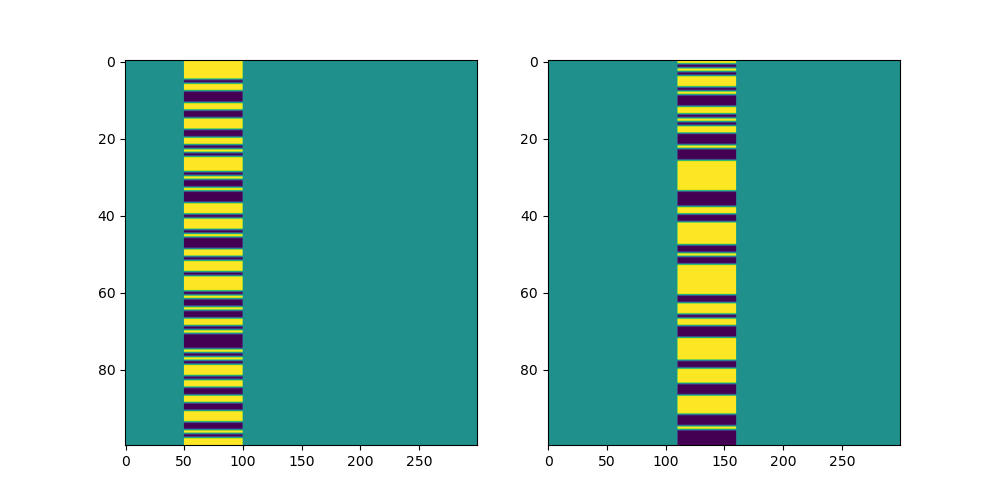

In [28]:
settings = {
        'T': 300, # trial duration (in steps)
        'stim_on': 50, # input stim onset (in steps)
        'stim_dur': 50, # input stim duration (in steps)
        'delay': 10, # delay b/w the two stimuli (in steps)
        'DeltaT': 1, # sampling rate
        'taus': 20, # decay time-constants (in steps)
        'task': 'xor', # task name
        }
inputs = np.zeros((100, 2, settings['T']))
for i in range(100):
    u, label = generate_input_stim_xor(settings)
    inputs[i, :, :] = u
# Plotting the generated trials
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(inputs[:, 0, :], aspect='auto')
axs[1].imshow(inputs[:, 1, :], aspect='auto')
plt.show()

In [12]:
import importlib
import model 

(200, 300)
(200, 300)
(300,)


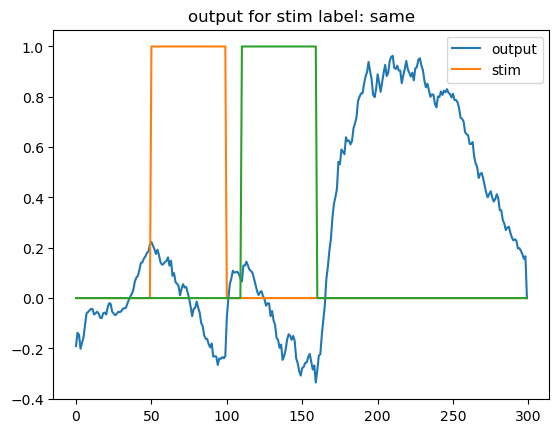

In [14]:

x, r, o, _ = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=u)
print(x.shape)
print(r.shape)
print(o.shape)

plt.figure()
plt.plot(o)
plt.plot(u[0,:])
plt.plot(u[1,:])
plt.title(f'output for stim label: {label}')
plt.legend(['output','stim'])
plt.show()

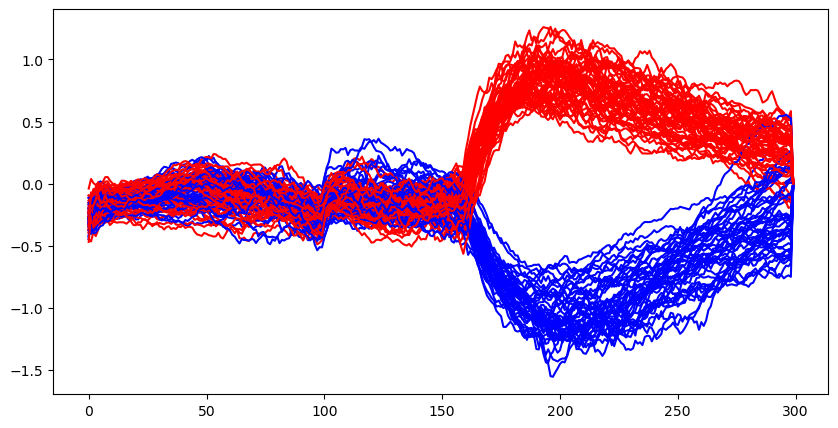

Performance: 0.95


In [15]:
# model eval on 100 random trials

n_trials = 100
resp_onset = settings['stim_on'] + 2*settings['stim_dur'] + settings['delay']
eval_amp_threshold = 0.7
eval_perf = np.zeros(n_trials)

plt.figure(figsize=(10, 5))
for i in range(n_trials):
    eval_u, eval_label = generate_input_stim_xor(settings)
    _, _, eval_o, _ = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=eval_u)
    if eval_label == 'same':
        if np.max(eval_o[resp_onset:]) > eval_amp_threshold:
            eval_perf[i] = 1
            plt.plot(eval_o, c='r')
    else:
        if np.min(eval_o[resp_onset:]) < -eval_amp_threshold:
            eval_perf[i] = 1
            plt.plot(eval_o, c='b')
    
plt.show()
eval_perf_mean = np.nanmean(eval_perf)
print("Performance: %.2f"%(eval_perf_mean))

### plotting model firing rates r, and synaptic current x

In [16]:
r = mat_data['r']
x = mat_data['x']
print(r.shape)
print(x.shape)

(300, 200, 1)
(300, 200, 1)


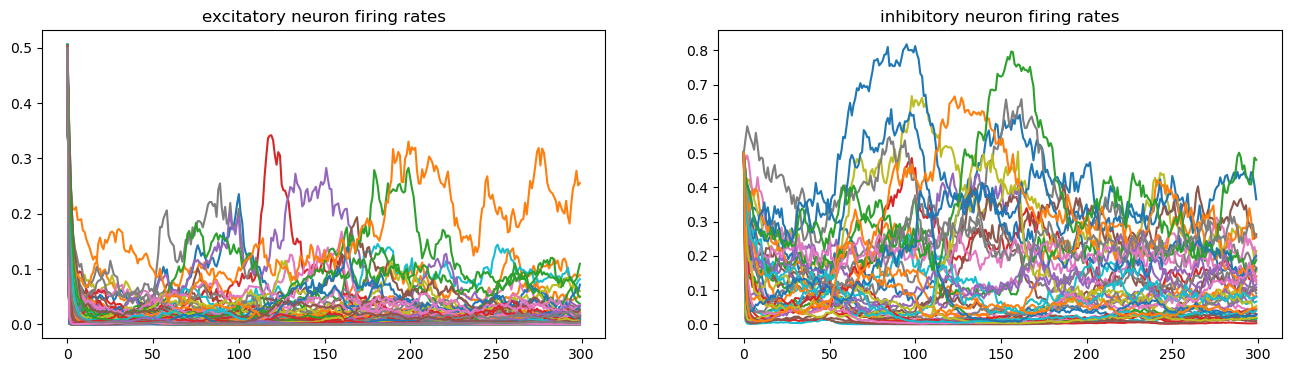

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(r[:,exc_ind,0])
axs[0].set_title('excitatory neuron firing rates')
axs[1].plot(r[:,inh_ind,0])
axs[1].set_title('inhibitory neuron firing rates')
plt.show()

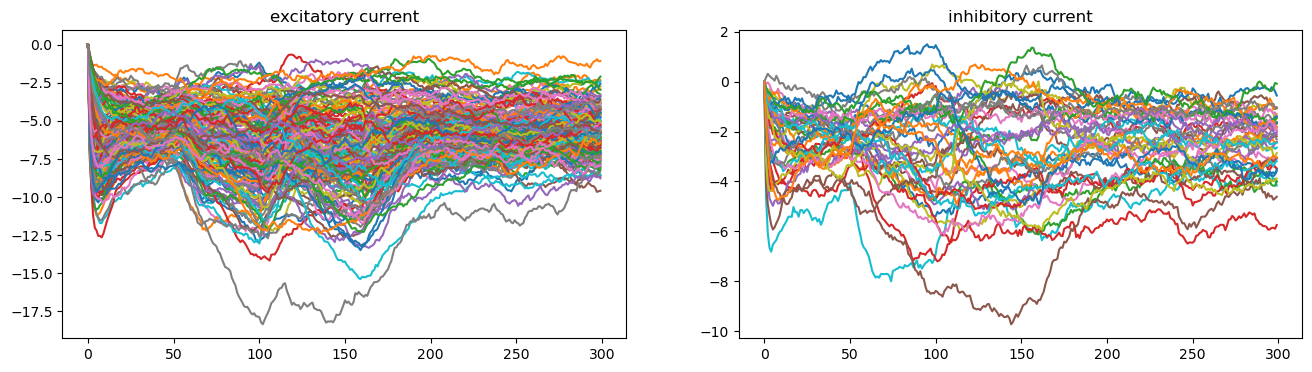

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(x[:,exc_ind,0])
axs[0].set_title('excitatory current')
axs[1].plot(x[:,inh_ind,0])
axs[1].set_title('inhibitory current')
plt.show()

### plotting model outputs r and x from multiple trials

#### trying to get EPSPs from current

### Trajectory plots

In [20]:

from sklearn.decomposition import PCA


In [21]:
r = mat_data['r'][:,:,0]
r.shape

(300, 200)

X (r): time x neurons  

U: time x n_components  

S: n_components  

Vt: n_components x neurons  

In [22]:
# X = USVt

pca = PCA(n_components=100).fit(r)
r_U = pca.transform(r)
r_S = pca.singular_values_
r_Vt = pca.components_

print(r_U.shape)
print(r_S.shape)
print(r_Vt.shape)

(300, 100)
(100,)
(100, 200)


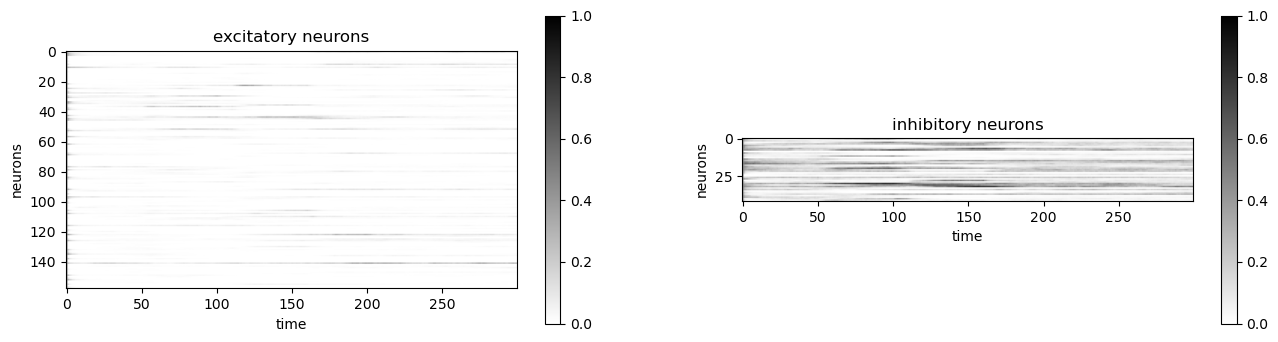

158 excitatory neurons
42 inhibitory neurons


In [23]:
fig,axs = plt.subplots(1,2,figsize=(16,4))
im1 = axs[0].imshow(r[:,exc_ind].T,cmap='binary',vmin=0, vmax=1)
axs[0].set_xlabel('time')
axs[0].set_ylabel('neurons')
axs[0].set_title('excitatory neurons')
fig.colorbar(im1)

im2 = axs[1].imshow(r[:,inh_ind].T,cmap='binary',vmin=0, vmax=1)
axs[1].set_xlabel('time')
axs[1].set_ylabel('neurons')
axs[1].set_title('inhibitory neurons')
fig.colorbar(im2)

plt.show()

print(f'{len(exc_ind)} excitatory neurons')
print(f'{len(inh_ind)} inhibitory neurons')

In [24]:
%matplotlib ipympl 
from mpl_toolkits.mplot3d import axes3d
# %matplotlib widget

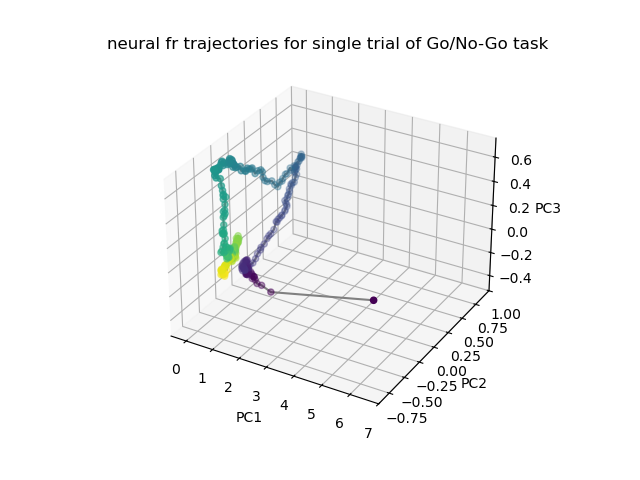

In [25]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(r_U[:,0], r_U[:,1], r_U[:,2], c=range(r_U.shape[0]))
ax.plot3D(r_U[:,0], r_U[:,1], r_U[:,2], 'gray')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('neural fr trajectories for single trial of Go/No-Go task')
plt.show()

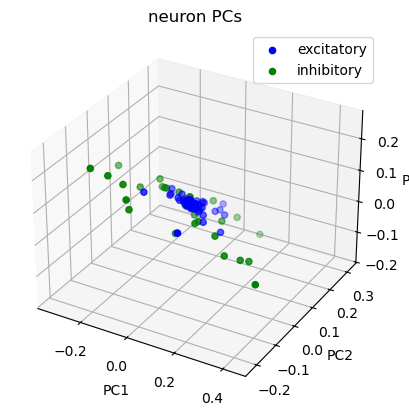

In [31]:
# neuron PCs 1, 2, 3
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(r_Vt[0,exc_ind],r_Vt[1,exc_ind], r_Vt[2,exc_ind],c='b')
ax.scatter(r_Vt[0,inh_ind],r_Vt[1,inh_ind], r_Vt[2,inh_ind], c='g')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(['excitatory','inhibitory'])
ax.set_title('neuron PCs')
plt.show()

#### plot separate trajectories for excitatory vs inhibitory

In [32]:
# X = USVt

# excitatory
pca_exc = PCA(n_components=10).fit(r[:,exc_ind])
r_U_exc = pca_exc.transform(r[:,exc_ind])
print(r_U_exc.shape)

# inhibitory
pca_inh = PCA(n_components=10).fit(r[:,inh_ind])
r_U_inh = pca_inh.transform(r[:,inh_ind])
print(r_U_inh.shape)

(300, 10)
(300, 10)


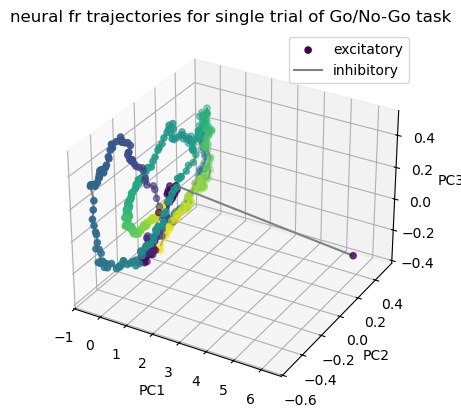

In [34]:
ax = plt.figure().add_subplot(projection='3d')

ax.scatter(r_U_exc[:,0], r_U_exc[:,1], r_U_exc[:,2], c=range(r_U_exc.shape[0]))
ax.plot3D(r_U_exc[:,0], r_U_exc[:,1], r_U_exc[:,2], 'gray')

ax.scatter(r_U_inh[:,0], r_U_inh[:,1], r_U_inh[:,2], c=range(r_U_inh.shape[0]))
ax.plot3D(r_U_inh[:,0], r_U_inh[:,1], r_U_inh[:,2], 'gray')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('neural fr trajectories for single trial of Go/No-Go task')
ax.legend(['excitatory','inhibitory'])
plt.show()

#### plot separate trajectories for multiple trials (colored by go / no-go)

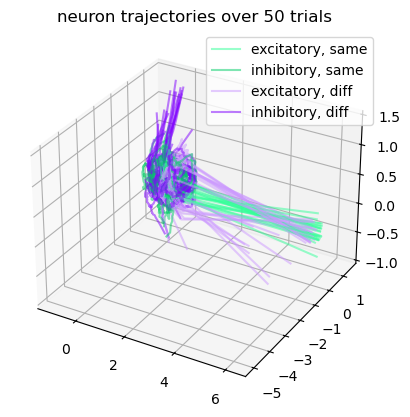

Performance: 0.98


In [36]:
# model eval on 50 random trials

n_trials = 50
n_neurons = 200
eval_amp_threshold = 0.7
eval_perf = np.zeros(n_trials)
resp_onset = settings['stim_on'] + 2*settings['stim_dur'] + settings['delay']

ax = plt.figure().add_subplot(projection='3d')
for i in range(n_trials):
    # generate trial
    u, label = generate_input_stim_xor(settings)
    x, r, o, _ = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=u)
    r = r.T
    
    # do PCA
    U_pcs_exc = PCA(n_components=10).fit(r[:,exc_ind]).transform(r[:,exc_ind])
    U_pcs_inh = PCA(n_components=10).fit(r[:,inh_ind]).transform(r[:,inh_ind])
    
    if label == 'same':
        line1, = ax.plot3D(U_pcs_exc[:,0], U_pcs_exc[:,1], U_pcs_exc[:,2], color='#33FF99', alpha=0.5) # excitatory
        # ax.scatter(U_pcs_exc[:,0], U_pcs_exc[:,1], U_pcs_exc[:,2], c=(51,255,153))
        # ax.scatter(U_pcs_exc[resp_onset,0], U_pcs_exc[resp_onset,1], U_pcs_exc[resp_onset,2], c='r')

        line2, = ax.plot3D(U_pcs_inh[:,0], U_pcs_inh[:,1], U_pcs_inh[:,2], color='#00CC66', alpha=0.5) # inhibitory

        if np.max(o[resp_onset:]) > eval_amp_threshold:
            eval_perf[i] = 1

    else: # diff
        line3, = ax.plot3D(U_pcs_exc[:,0], U_pcs_exc[:,1], U_pcs_exc[:,2], color='#CC99FF', alpha=0.5) # excitatory
        # ax.scatter(U_pcs_exc[:,0], U_pcs_exc[:,1], U_pcs_exc[:,2], c=(0,204,102))
        # ax.scatter(U_pcs_exc[resp_onset,0], U_pcs_exc[resp_onset,1], U_pcs_exc[resp_onset,2], c='r')
        line4, = ax.plot3D(U_pcs_inh[:,0], U_pcs_inh[:,1], U_pcs_inh[:,2], color='#7F00FF', alpha=0.5) # inhibitory

        if np.min(o[resp_onset:]) < -eval_amp_threshold:
            eval_perf[i] = 1


ax.set_title(f'neuron trajectories over {n_trials} trials')
plt.legend([line1, line2, line3, line4], ['excitatory, same','inhibitory, same', 'excitatory, diff','inhibitory, diff'])
plt.show()

eval_perf_mean = np.nanmean(eval_perf)
print("Performance: %.2f"%(eval_perf_mean))

#### Robert's wise words of advice
You could generate 25 trials for each case (+1/+1, +1/-1, -1/+1, -1/-1) and plot the average PCA trajectories (so a total of 4 trajectories) and see if they make sense: the trajectories with the same first stim should stick together until the second stim onset. 

In [30]:
def generate_xor_type(T, stim_on, stim_dur, delay, stim1=1, stim2=-1):
     
     u = np.zeros((2, T))
     
     u[0, stim_on:stim_on+stim_dur] = stim1
     u[1, stim_on+stim_dur+delay:stim_on+2*stim_dur+delay] = stim2

     if stim1 == stim2:
          label = 'same'
     else: 
          label = 'diff'
     
     return u, label

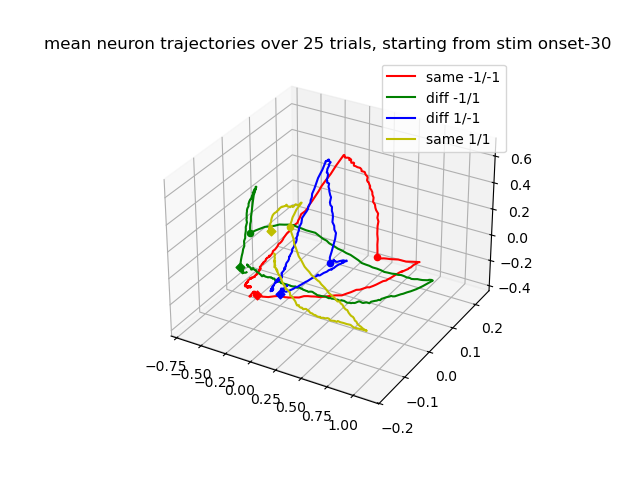

In [32]:
# model eval on 25 trials of each trial combo, plotting only after first stimulus

n_trials = 25
n_neurons = 200
n_pcs = 3
eval_amp_threshold = 0.7
eval_perf = np.zeros(n_trials)
resp_onset = settings['stim_on'] + 2*settings['stim_dur'] + settings['delay']
stim1_onset = settings['stim_on']
stim2_onset = settings['stim_on'] + settings['stim_dur'] + settings['delay']

stim1s = [-1, 1]
stim2s = [-1, 1]

ax = plt.figure().add_subplot(projection='3d')
colors = ['r','g','b','y']
U_pcs_mean_all = np.zeros((len(stim1s)+len(stim2s), settings['T'], n_pcs))
for i, stim1 in enumerate(stim1s):
    for j, stim2 in enumerate(stim2s):
        u, label = generate_xor_type(settings['T'], settings['stim_on'], settings['stim_dur'], settings['delay'], stim1, stim2)

        U_pcs_all = np.zeros((n_trials, settings['T'], n_pcs))
        for k in range(n_trials):
            x, r, o, _ = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=u)
            r = r.T

            # do PCA
            U_pcs_all[k,:,:] = PCA(n_components=n_pcs).fit(r).transform(r)
        U_pcs_mean = np.mean(U_pcs_all, axis=0)
        U_pcs_mean_all[2*i+j,:,:] = U_pcs_mean
        ax.plot3D(U_pcs_mean[stim1_onset-30:,0], U_pcs_mean[stim1_onset-30:,1], U_pcs_mean[stim1_onset-30:,2], 
                  label=f'{label} {stim1}/{stim2}', c=colors[2*i+j])
        
        ax.scatter(U_pcs_mean[stim1_onset,0], 
                   U_pcs_mean[stim1_onset,1], 
                   U_pcs_mean[stim1_onset,2], 
                   c=colors[2*i+j], marker="D")
        ax.scatter(U_pcs_mean[stim2_onset,0], 
                   U_pcs_mean[stim2_onset,1], 
                   U_pcs_mean[stim2_onset,2], 
                   c=colors[2*i+j])

ax.set_title(f'mean neuron trajectories over {n_trials} trials, starting from stim onset-30')
ax.legend()
plt.show()

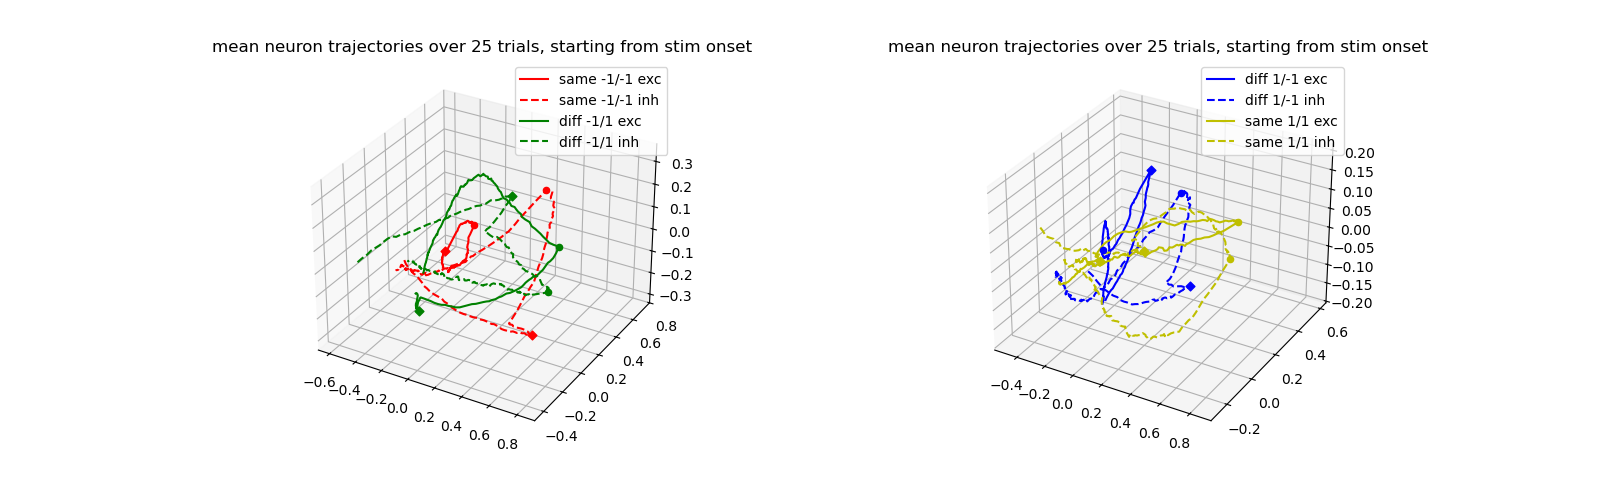

In [34]:
# model eval on 25 trials of each trial combo, splitting exc/inh neurons

n_trials = 25
n_neurons = 200
n_pcs = 3
eval_amp_threshold = 0.7
eval_perf = np.zeros(n_trials)
resp_onset = settings['stim_on'] + 2*settings['stim_dur'] + settings['delay']

stim1s = [-1, 1]
stim2s = [-1, 1]

fig, axs = plt.subplots(1,2,figsize=(16,5),subplot_kw=dict(projection='3d'))
colors = ['r','g','b','y']
for i, stim1 in enumerate(stim1s):
    for j, stim2 in enumerate(stim2s):
        u, label = generate_xor_type(settings['T'], settings['stim_on'], settings['stim_dur'], settings['delay'], stim1, stim2)

        U_pcs_all_exc = np.zeros((n_trials, settings['T'], n_pcs))
        U_pcs_all_inh = np.zeros((n_trials, settings['T'], n_pcs))
        for k in range(n_trials):
            x, r, o, _ = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=u)
            r = r.T

            # do PCA
            U_pcs_all_exc[k,:,:] = PCA(n_components=n_pcs).fit(r[:,exc_ind]).transform(r[:,exc_ind])
            U_pcs_all_inh[k,:,:] = PCA(n_components=n_pcs).fit(r[:,inh_ind]).transform(r[:,inh_ind])
        U_pcs_mean_exc = np.mean(U_pcs_all_exc, axis=0)
        U_pcs_mean_inh = np.mean(U_pcs_all_inh, axis=0)
        axs[i].plot3D(U_pcs_mean_exc[settings['stim_on']:,0], U_pcs_mean_exc[settings['stim_on']:,1], U_pcs_mean_exc[settings['stim_on']:,2], 
                  label=f'{label} {stim1}/{stim2} exc', c=colors[2*i+j])
        axs[i].plot3D(U_pcs_mean_inh[settings['stim_on']:,0], U_pcs_mean_inh[settings['stim_on']:,1], U_pcs_mean_inh[settings['stim_on']:,2],
                  label=f'{label} {stim1}/{stim2} inh', c=colors[2*i+j], linestyle='--')
        

        axs[i].scatter(U_pcs_mean_exc[settings['stim_on']+settings['stim_dur'],0], 
                   U_pcs_mean_exc[settings['stim_on']+settings['stim_dur'],1], 
                   U_pcs_mean_exc[settings['stim_on']+settings['stim_dur'],2], 
                   c=colors[2*i+j], marker="D")
        axs[i].scatter(U_pcs_mean_exc[resp_onset,0], 
                   U_pcs_mean_exc[resp_onset,1], 
                   U_pcs_mean_exc[resp_onset,2], 
                   c=colors[2*i+j])
        
        axs[i].scatter(U_pcs_mean_inh[settings['stim_on']+settings['stim_dur'],0],
                   U_pcs_mean_inh[settings['stim_on']+settings['stim_dur'],1],
                   U_pcs_mean_inh[settings['stim_on']+settings['stim_dur'],2],
                   c=colors[2*i+j], marker="D")
        axs[i].scatter(U_pcs_mean_inh[resp_onset,0],
                   U_pcs_mean_inh[resp_onset,1],
                   U_pcs_mean_inh[resp_onset,2],
                   c=colors[2*i+j])

    axs[i].set_title(f'mean neuron trajectories over {n_trials} trials, starting from stim onset')
    axs[i].legend()
plt.show()

#### getting IPSCs from spiking model

In [40]:
ipsc_data = scipy.io.loadmat(os.path.join(model_dir, model_fname[:-4], 'IPSCs.mat'))
ipsc_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'diff_IPSCs', 'same_IPSCs'])

In [41]:
same_IPSCs = ipsc_data['same_IPSCs']
diff_IPSCs = ipsc_data['diff_IPSCs']
print(same_IPSCs.shape)
print(diff_IPSCs.shape)

(200, 30000)
(200, 30000)


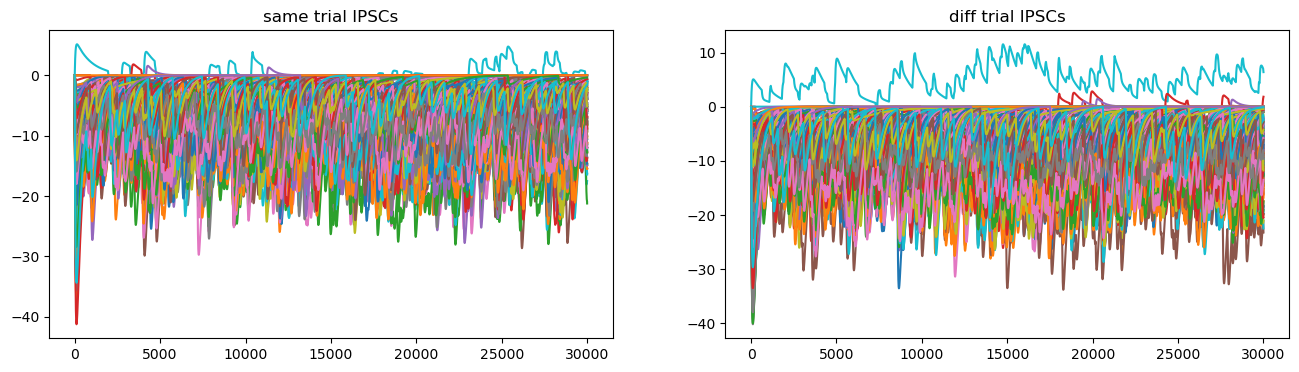

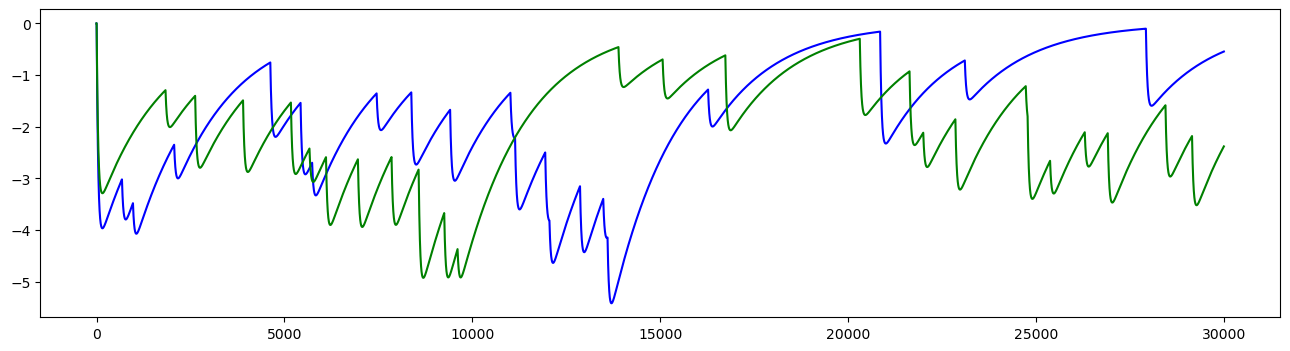

In [42]:
fig, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].plot(same_IPSCs.T)
axs[0].set_title('same trial IPSCs')
axs[1].plot(diff_IPSCs.T)
axs[1].set_title('diff trial IPSCs')
plt.show()

plt.figure(figsize=(16,4))
plt.plot(same_IPSCs[0,:].T, c='b')
plt.plot(diff_IPSCs[0,:].T, c='g')
plt.show()

### Spectrograms for IPSCs

In [43]:
from scipy.signal import spectrogram

(13,)
(1363,)
(200, 13, 1363)
[6.250000e-04 1.725000e-03 2.825000e-03 ... 1.496625e+00 1.497725e+00
 1.498825e+00]
[   0.  800. 1600. 2400. 3200. 4000. 4800. 5600. 6400. 7200. 8000. 8800.
 9600.]


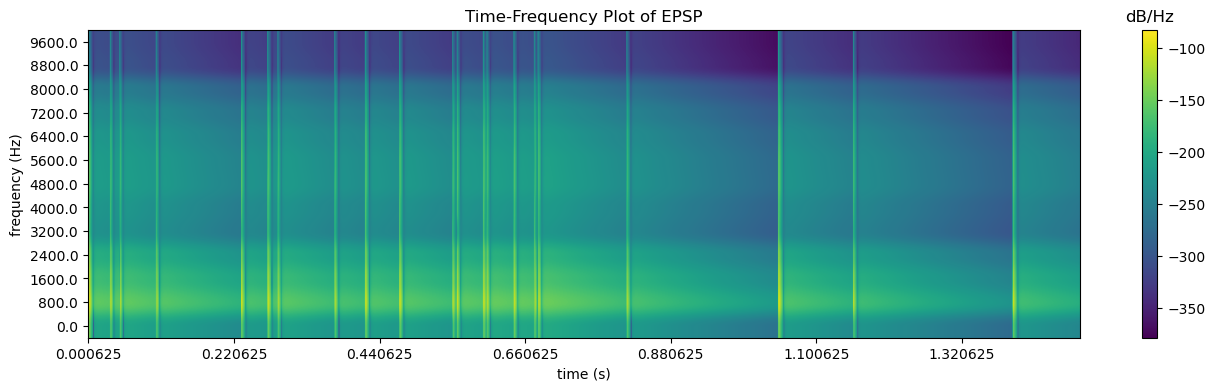

In [44]:
fs = 20000
nperseg=25

f, t, s = spectrogram(same_IPSCs, fs=fs, window=('tukey', 0.25), scaling='density', 
                      nperseg=nperseg)
# s = s[:,:,0]
print(f.shape)
print(t.shape)
print(s.shape)

print(t)
print(f)


plt.figure(figsize=(16,4))
plt.imshow(10*np.log(s[0,:,:]), aspect='auto', origin='lower')
plt.xlabel('time (s)')
plt.xticks(range(len(t))[::200],t[::200])
plt.ylabel('frequency (Hz)')
plt.yticks(range(len(f)),f)
cbar = plt.colorbar()
cbar.ax.set_title('dB/Hz')
plt.title('Time-Frequency Plot of EPSP')
plt.show()

In [17]:
def upsample(signal, fs, upsample_fs):
    # signal is (neurons x time)

    down_time = np.linspace(0, 1, fs)
    up_time = np.linspace(0, 1, upsample_fs)

    n_neurons = signal.shape[0]
    up_signal = np.zeros((n_neurons,len(up_time)))
    for i in range(n_neurons):
        intp1 = scipy.interpolate.interp1d(down_time, signal[i,:], kind='linear')
        up_signal[i,:] = intp1(up_time)

    return up_signal

In [46]:
def calc_spect(signal, fs, nperseg, noverlap, nfft, f_cutoff, 
               plot=1, neuron_nums=[0], t_skip=5, f_skip=2, trial_label='same'):
    # signal is (neurons x time)
    # neuron_num is list of neuron numbers to plot

    f, t, s = spectrogram(signal, fs=fs, window=('tukey', 0.25), 
                          nperseg=nperseg, noverlap=noverlap, nfft=nfft, scaling='density')

    f_cutoff_idx = np.where(f <= f_cutoff)[0][-1]

    if plot:
        type_label = ['excitatory','inhibitory']
        for neuron_num in neuron_nums:
            fig, axs = plt.subplots(3,1,figsize=(16,14))
            
            axs[0].plot(signal[neuron_num,:])
            axs[0].set_title(f'"{trial_label}" trial IPSC, neuron {neuron_num}, {type_label[inh[neuron_num][0]]}')

            im = axs[1].imshow(10*np.log(s[neuron_num,:f_cutoff_idx,:]), 
                               aspect='auto', origin='lower')
            axs[1].set_xlabel('time (s)')
            axs[1].set_xticks(range(len(t))[::t_skip],t[::t_skip])
            axs[1].set_ylabel('frequency (Hz)')
            axs[1].set_yticks(range(len(f[:f_cutoff_idx]))[::f_skip],f[:f_cutoff_idx][::f_skip])
            cbar = fig.colorbar(im)
            cbar.ax.set_title('dB/Hz')
            axs[1].set_title(f'Time-Frequency plot, nperseg={nperseg}, noverlap={noverlap}, nfft={nfft}')

            # plotting beta power (approx 13-30Hz)
            f_beta_idx = np.where((f >= 13) & (f <=30))[0]
            beta_power = 10*np.log(s[neuron_num,f_beta_idx,:])
            beta_mean = np.nanmean(beta_power, axis=0)
            beta_std = np.nanstd(beta_power, axis=0)
            beta_sem = np.sqrt(beta_std)/np.sqrt(beta_power.shape[0])

            axs[2].plot(beta_mean)
            axs[2].fill_between(range(len(beta_mean)), beta_mean - beta_sem, beta_mean + beta_sem, alpha=0.3)
            axs[2].set_xlabel('time (s)')
            axs[2].set_xticks(range(len(t))[::t_skip],t[::t_skip])
            axs[2].set_title('beta (13-30Hz) power')

            plt.show()

    return f, t, s

#### "same" trial

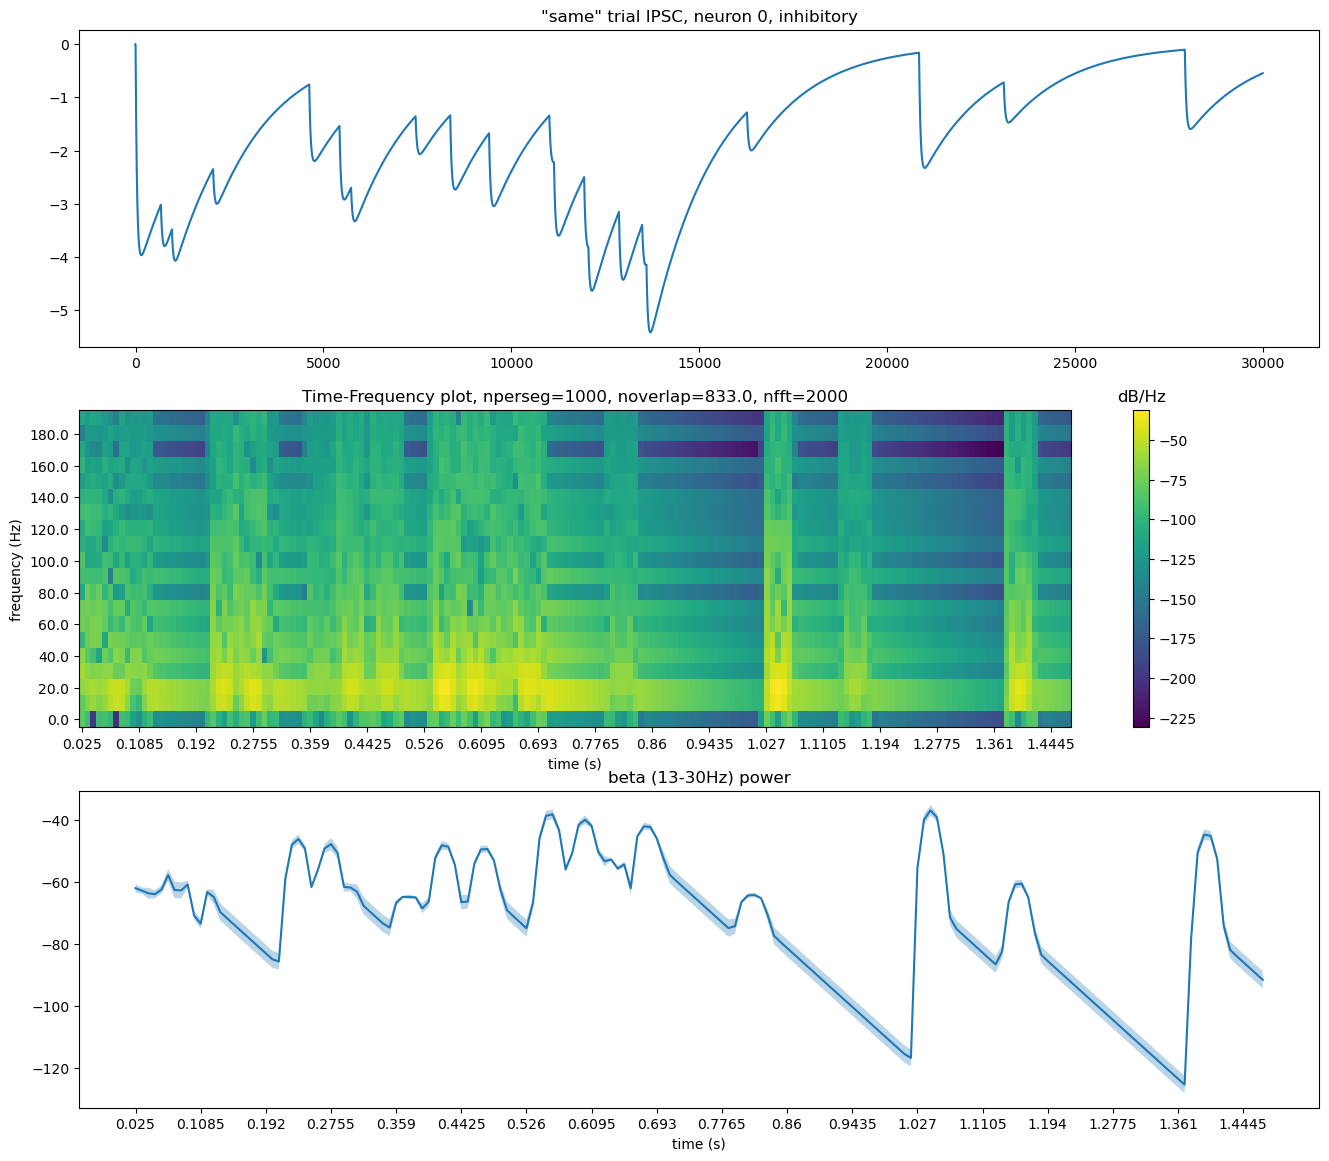

In [48]:
fs = 20000
nperseg=1000
noverlap = nperseg//1.2
nfft = nperseg*2
f_cutoff = 200

f, t, s = calc_spect(same_IPSCs, fs=fs, nperseg=nperseg, 
                     noverlap=noverlap, nfft=nfft, f_cutoff=f_cutoff, 
                     plot=1, neuron_nums=[0], t_skip=10, f_skip=2, trial_label='same')

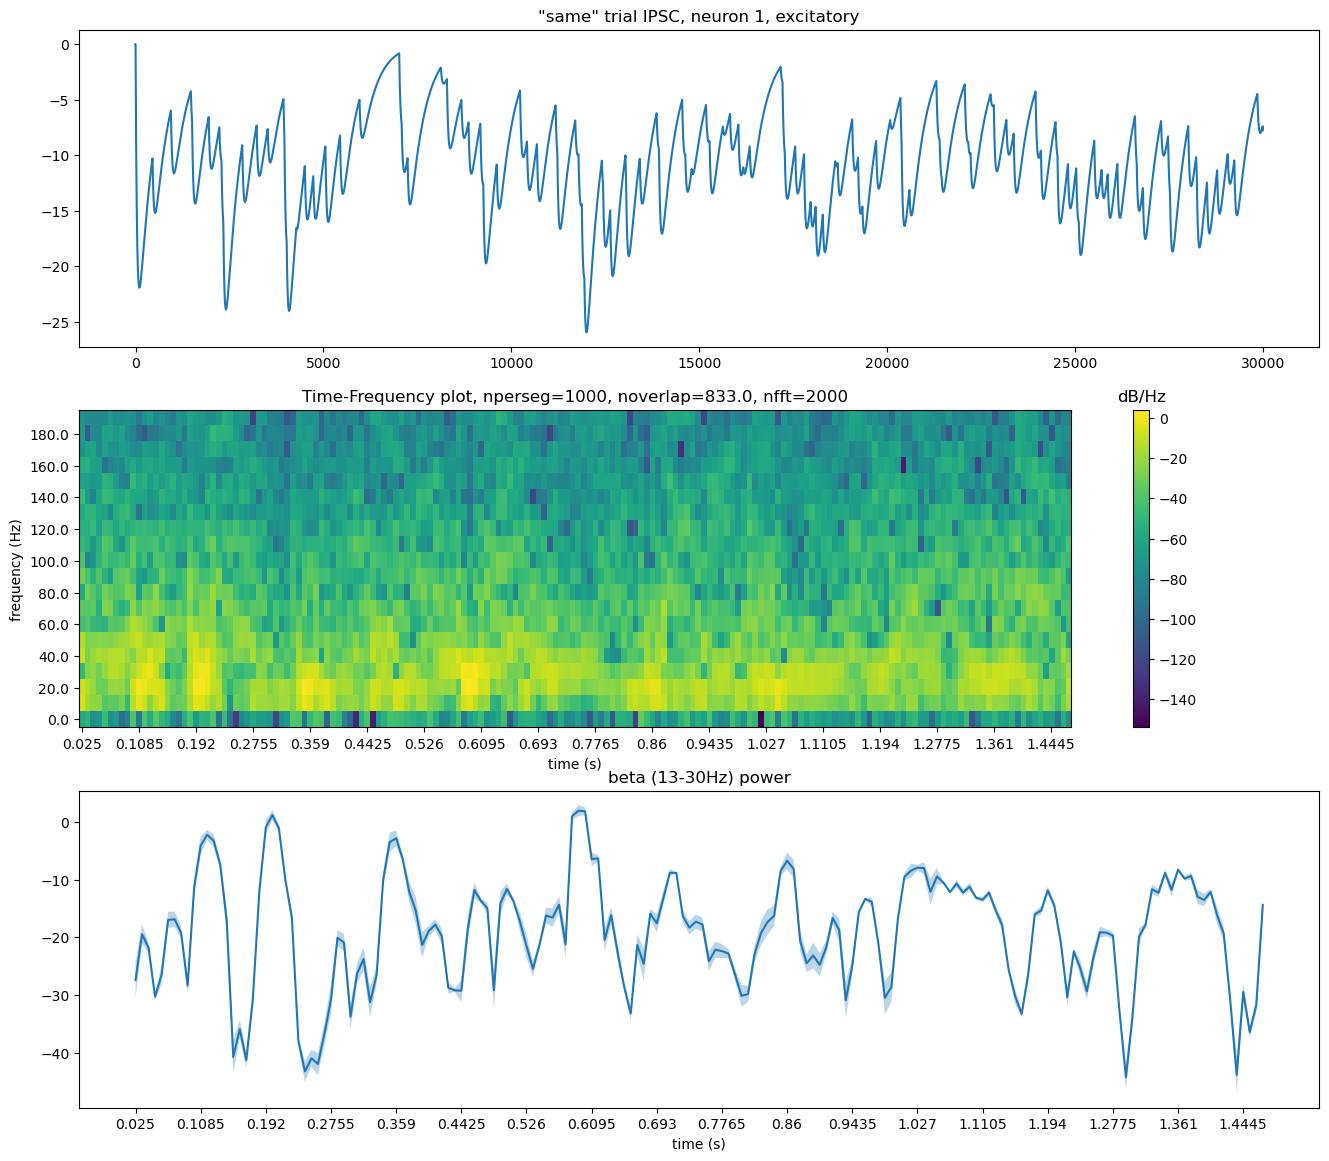

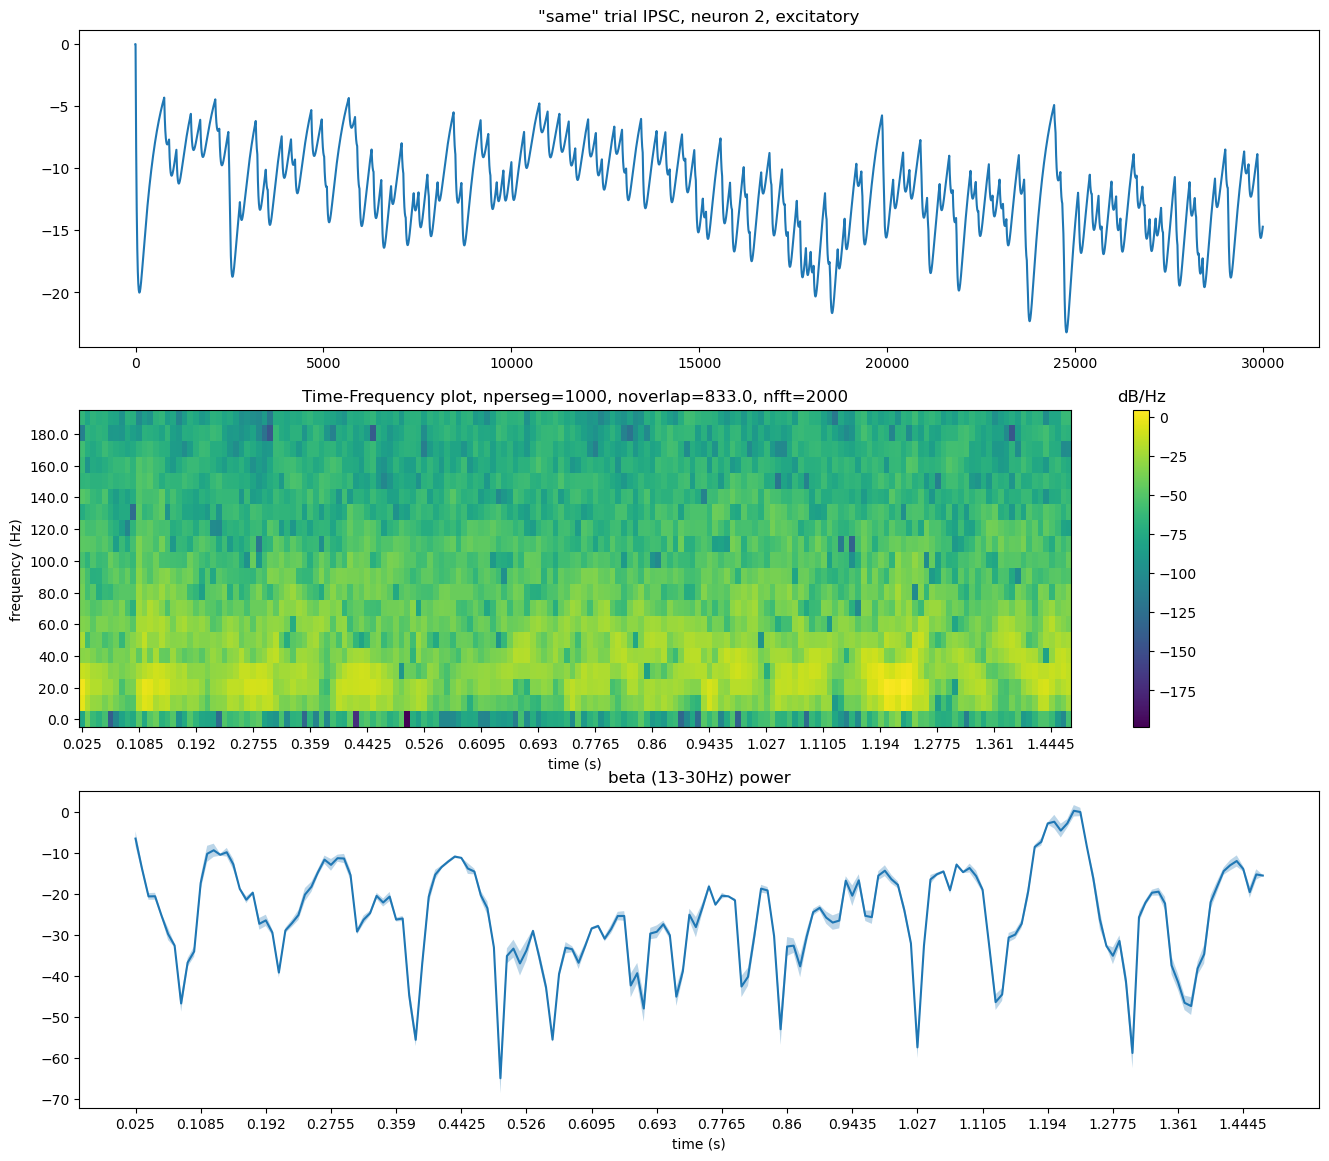

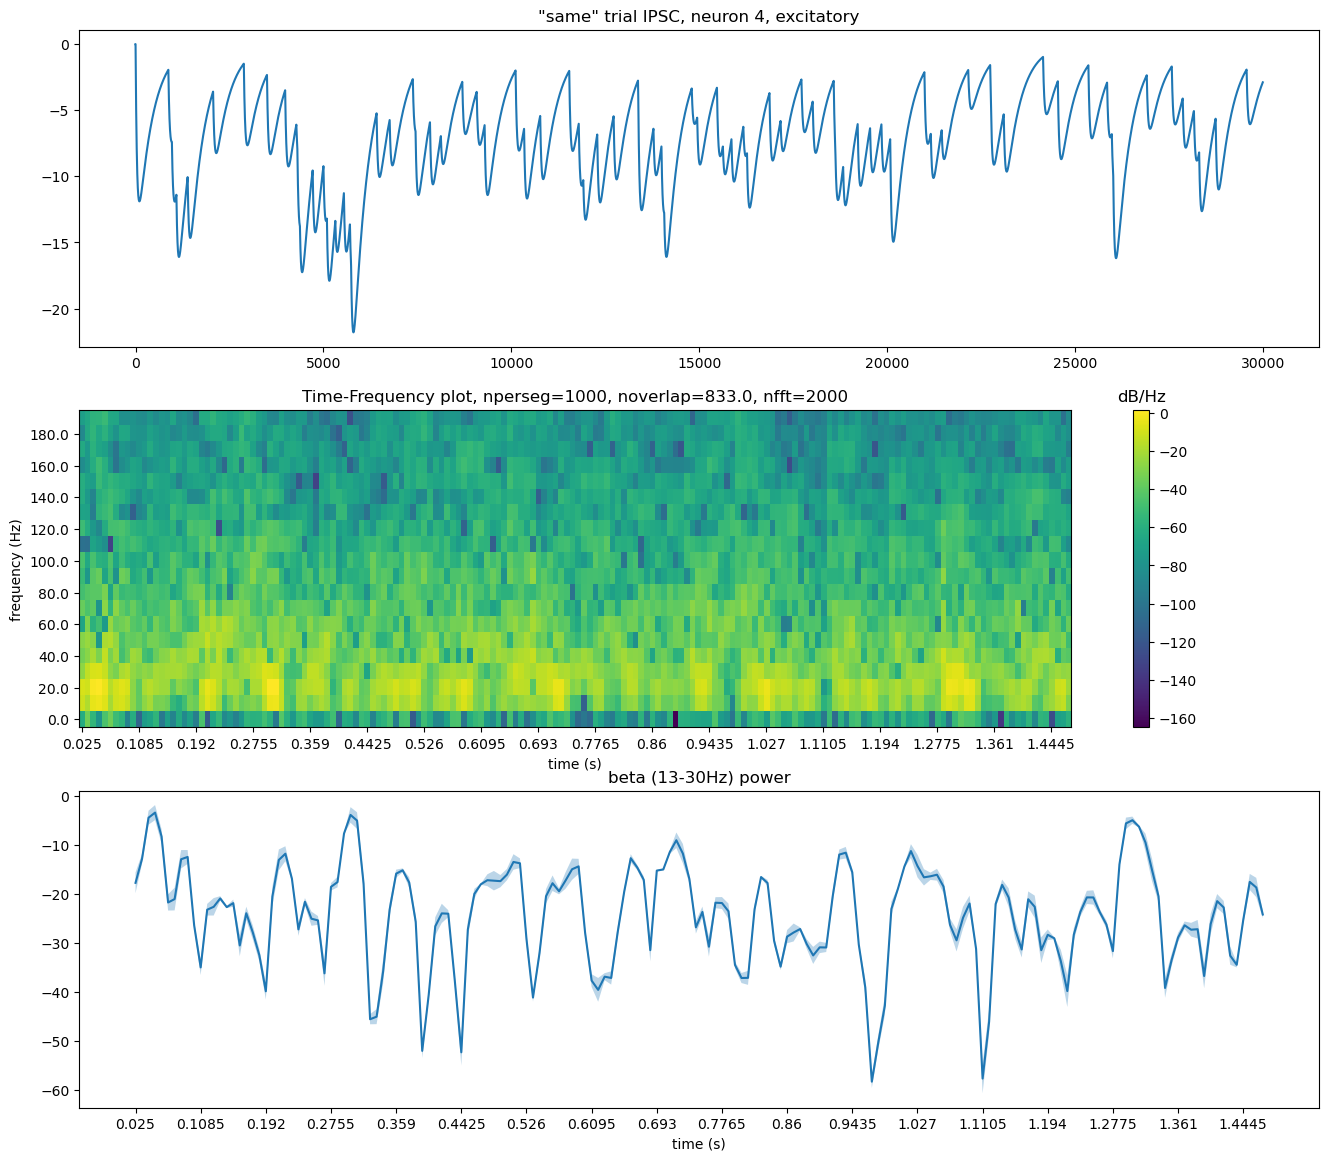

In [49]:
# plotting excitatory

fs = 20000
nperseg=1000
noverlap = nperseg//1.2
nfft = nperseg*2
f_cutoff = 200

f, t, s = calc_spect(same_IPSCs, fs=fs, nperseg=nperseg, 
                     noverlap=noverlap, nfft=nfft, f_cutoff=f_cutoff, 
                     plot=1, neuron_nums=exc_ind[:3], t_skip=10, f_skip=2, trial_label='same')

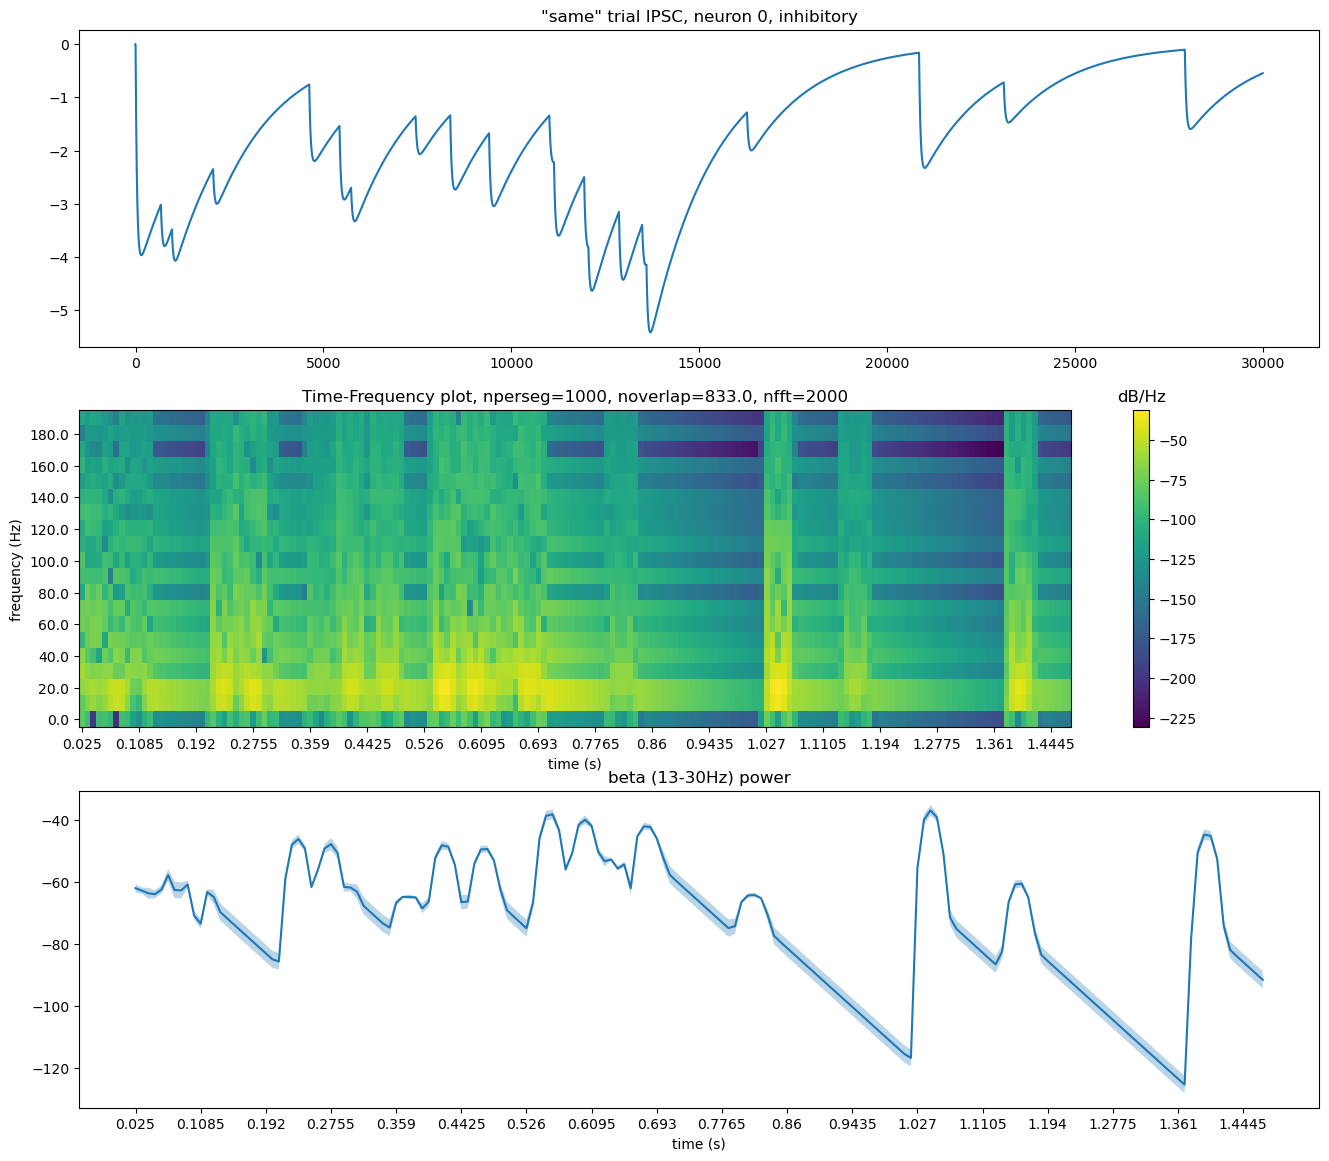

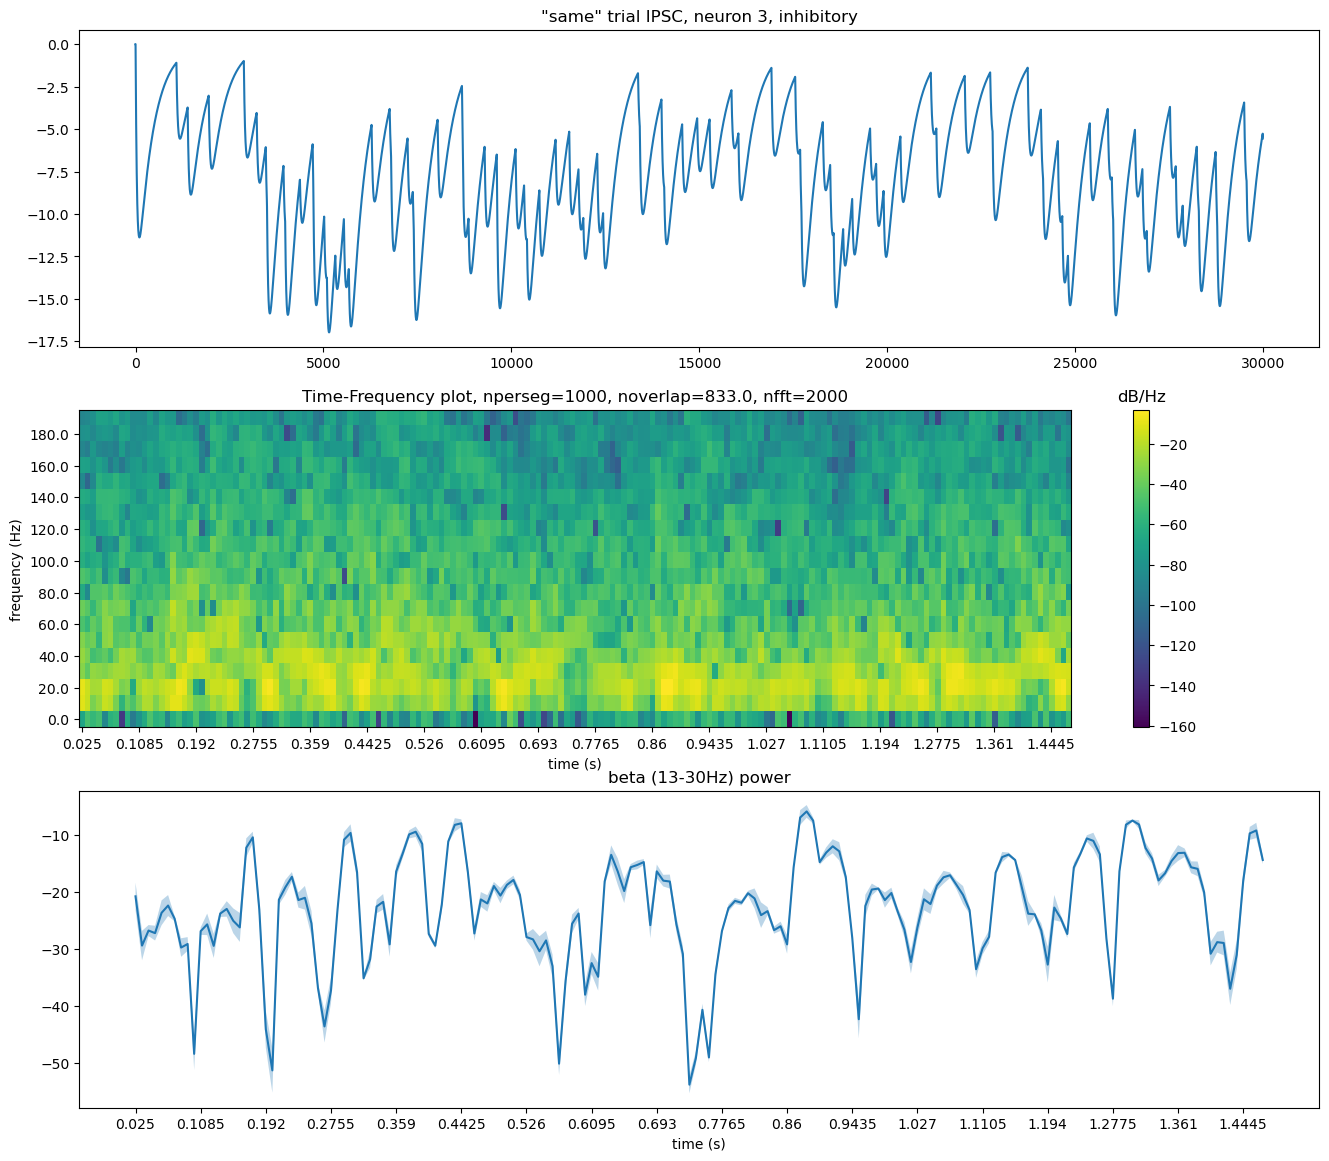

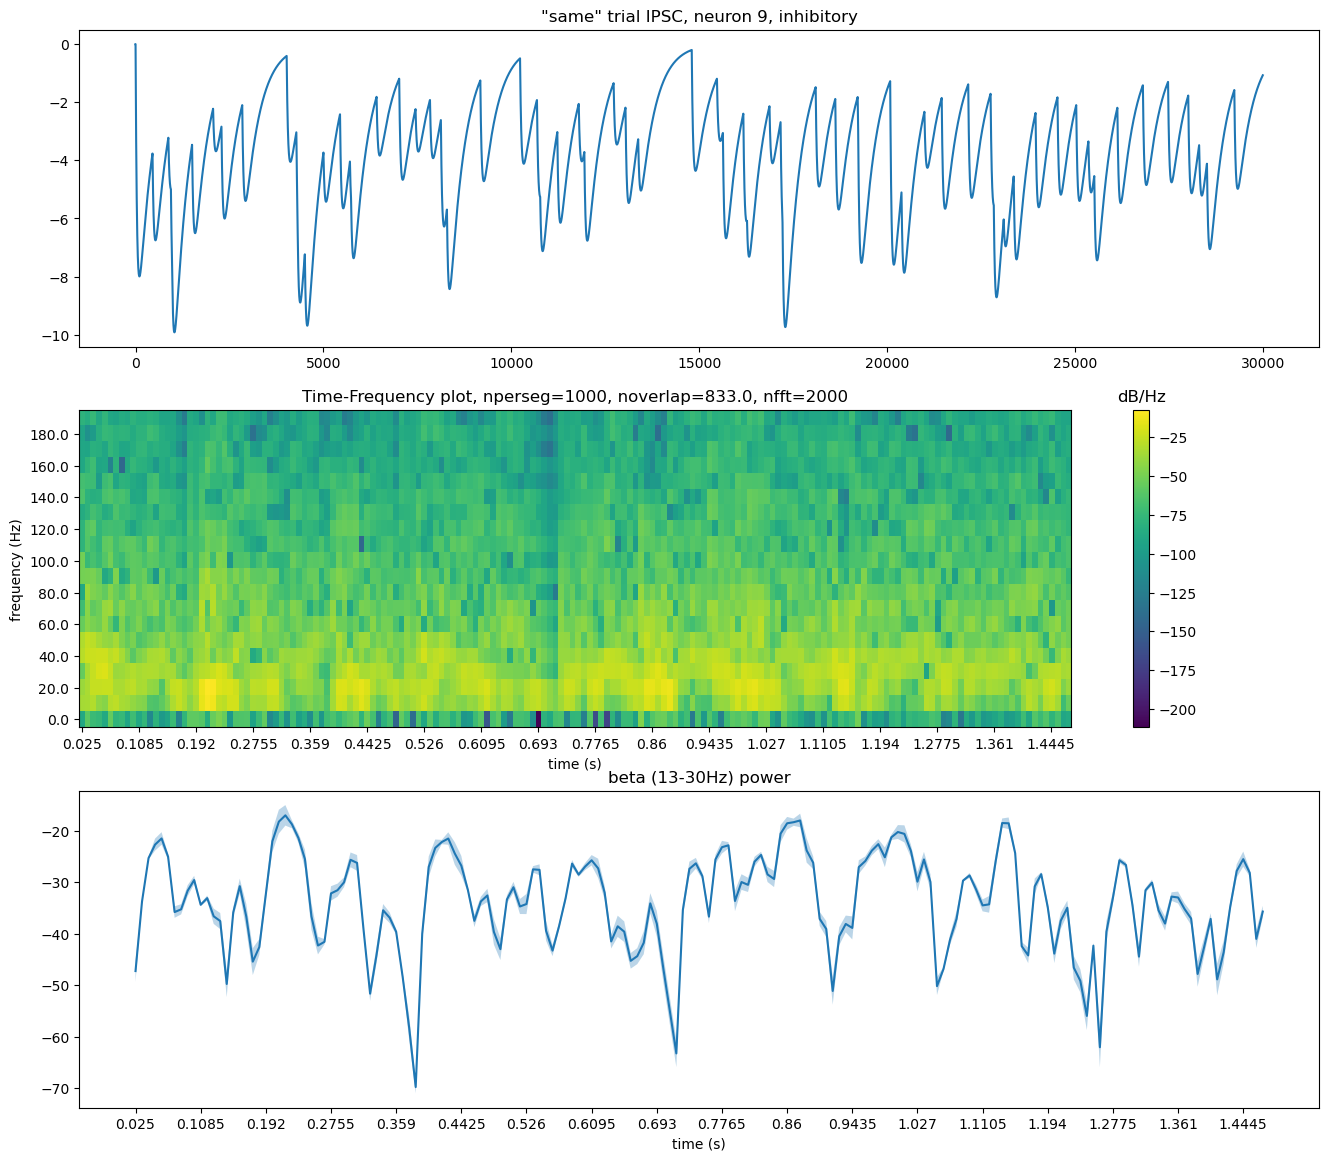

In [50]:
# plotting inhibitory

fs = 20000
nperseg=1000
noverlap = nperseg//1.2
nfft = nperseg*2
f_cutoff = 200

f, t, s = calc_spect(same_IPSCs, fs=fs, nperseg=nperseg, 
                     noverlap=noverlap, nfft=nfft, f_cutoff=f_cutoff, 
                     plot=1, neuron_nums=inh_ind[:3], t_skip=10, f_skip=2, trial_label='same')

#### "diff" trials

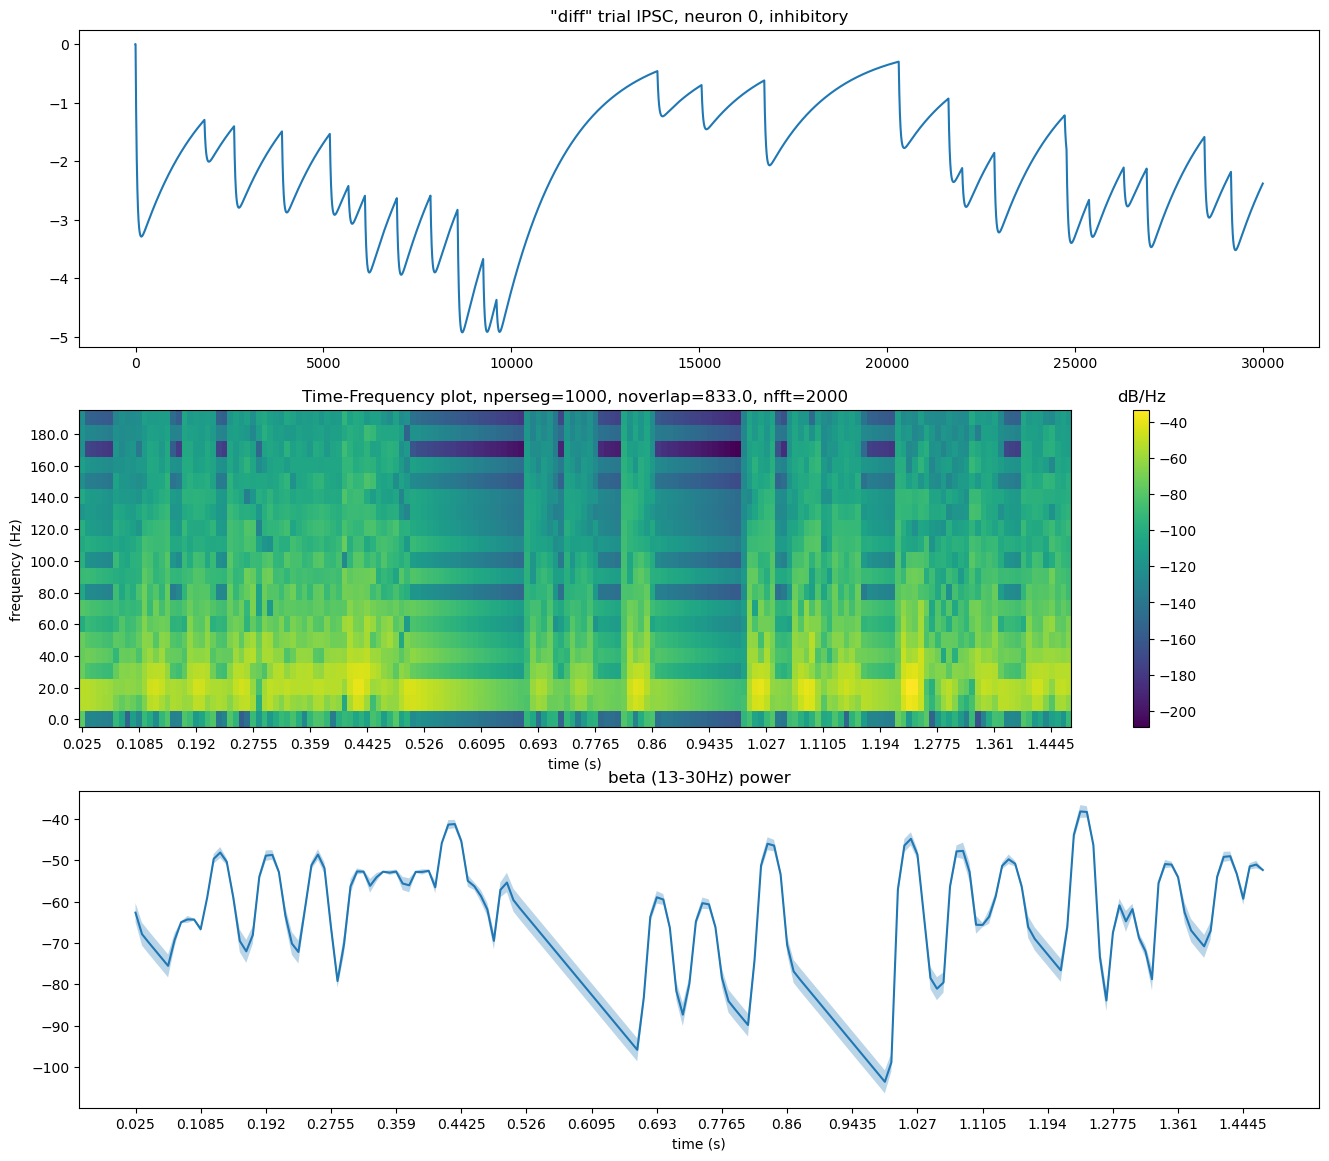

In [51]:
fs = 20000
nperseg=1000
noverlap = nperseg//1.2
nfft = nperseg*2
f_cutoff = 200

f, t, s = calc_spect(diff_IPSCs, fs=fs, nperseg=nperseg, 
                     noverlap=noverlap, nfft=nfft, f_cutoff=f_cutoff, 
                     plot=1, neuron_nums=[0], t_skip=10, f_skip=2, trial_label='diff')

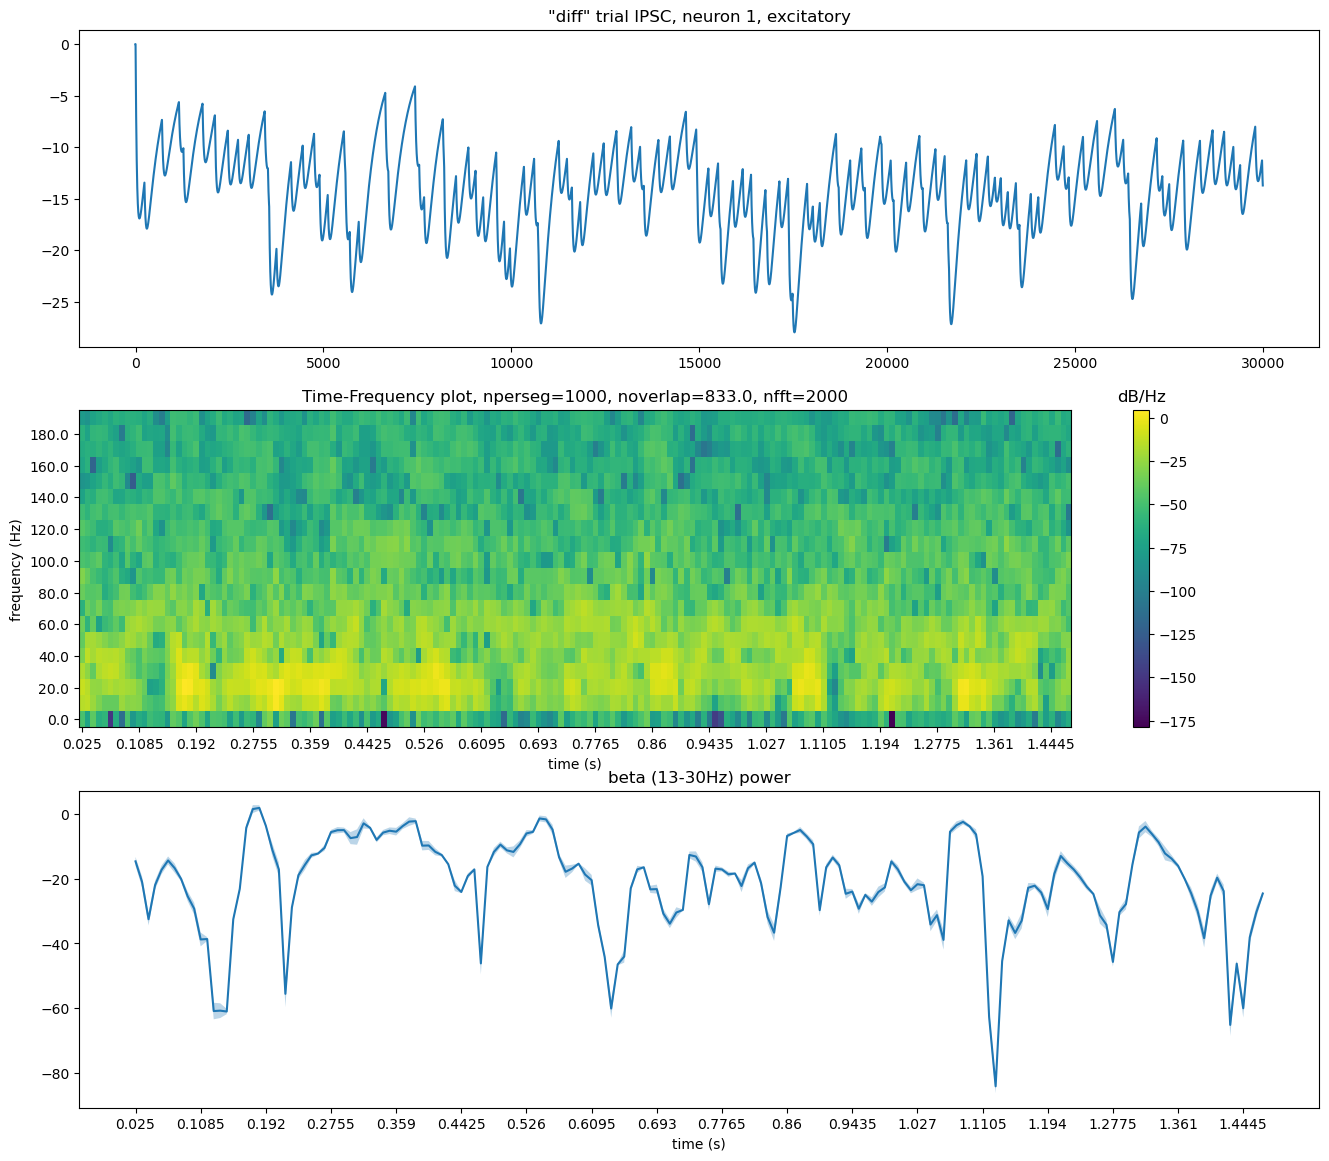

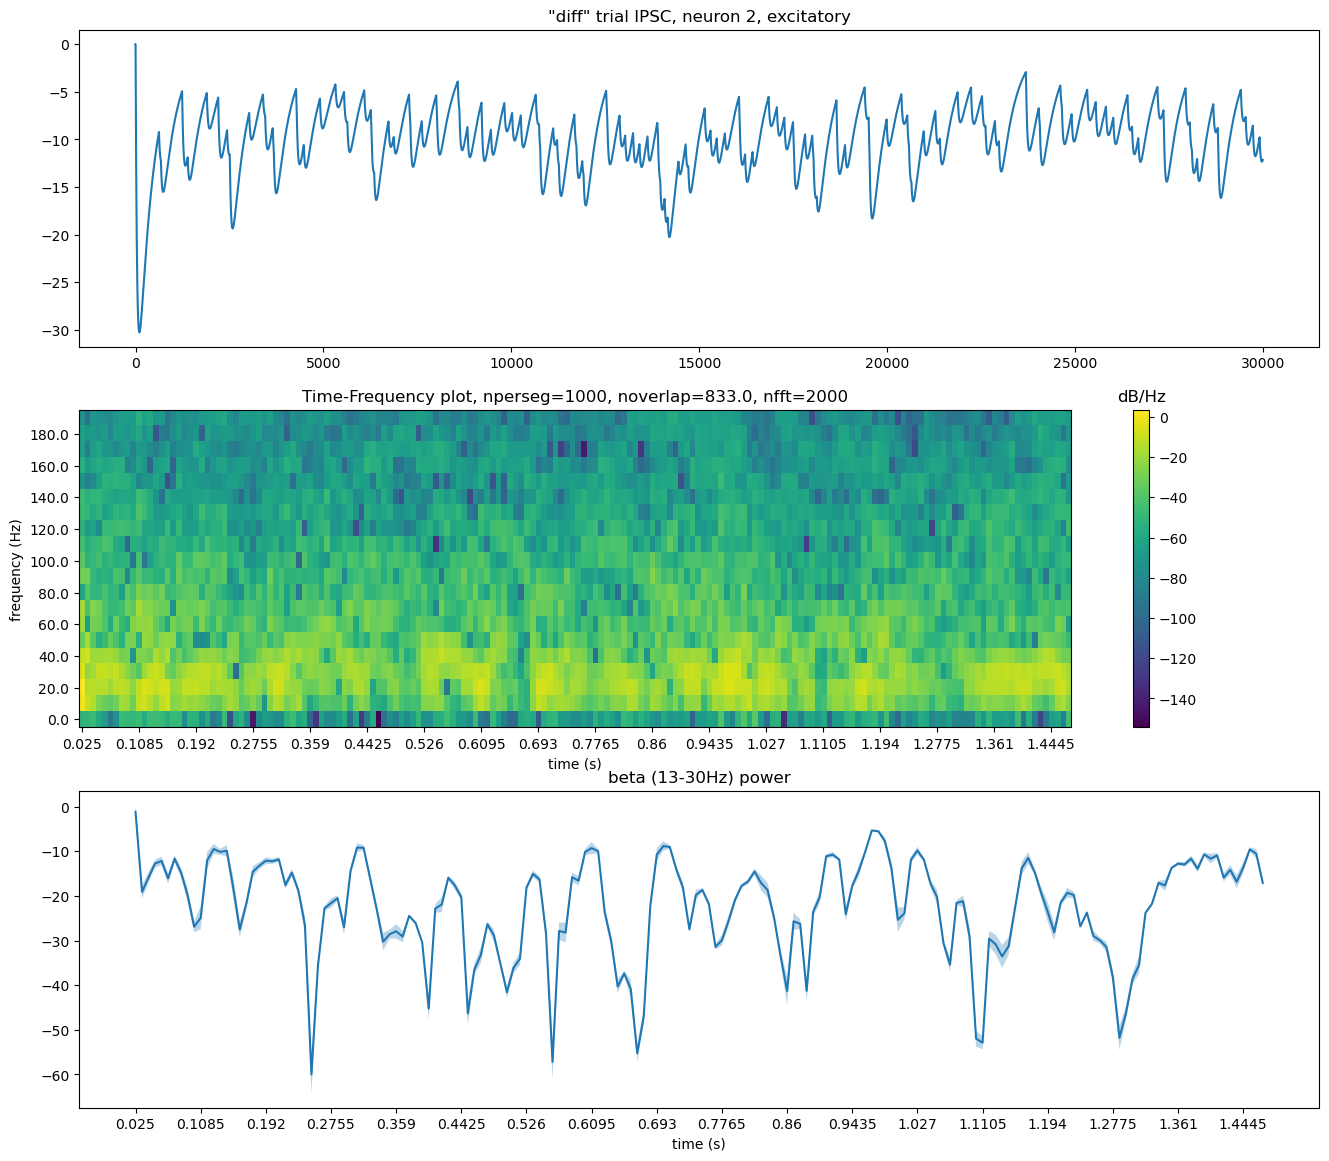

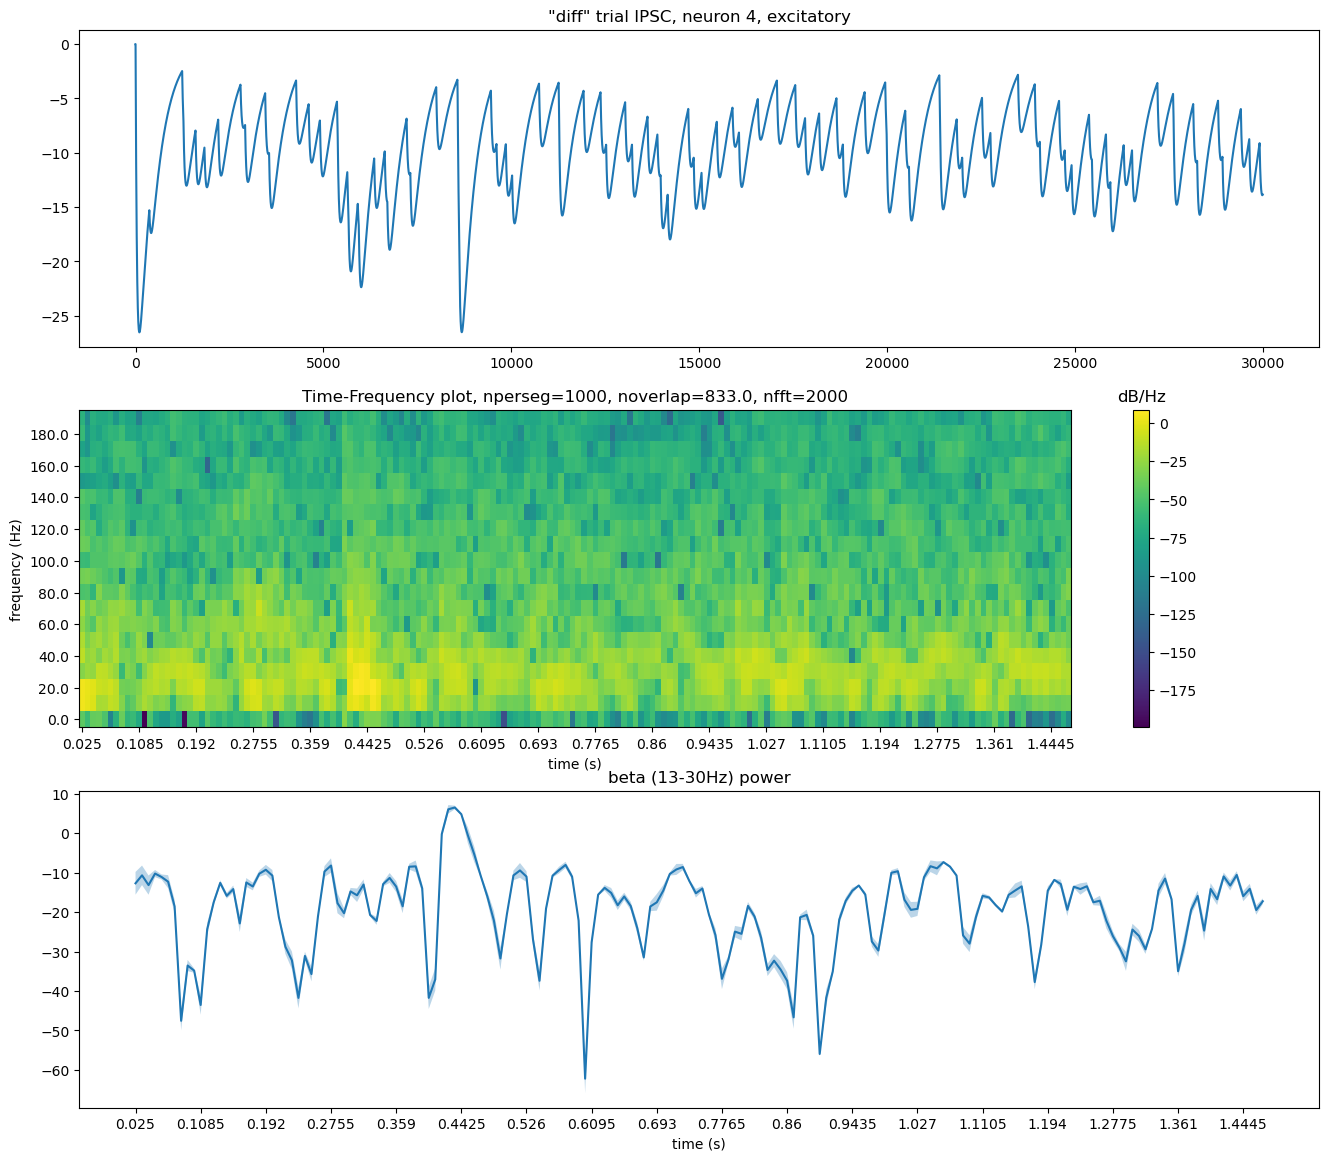

In [52]:
# plotting excitatory

fs = 20000
nperseg=1000
noverlap = nperseg//1.2
nfft = nperseg*2
f_cutoff = 200

f, t, s = calc_spect(diff_IPSCs, fs=fs, nperseg=nperseg, 
                     noverlap=noverlap, nfft=nfft, f_cutoff=f_cutoff, 
                     plot=1, neuron_nums=exc_ind[:3], t_skip=10, f_skip=2, trial_label='diff')

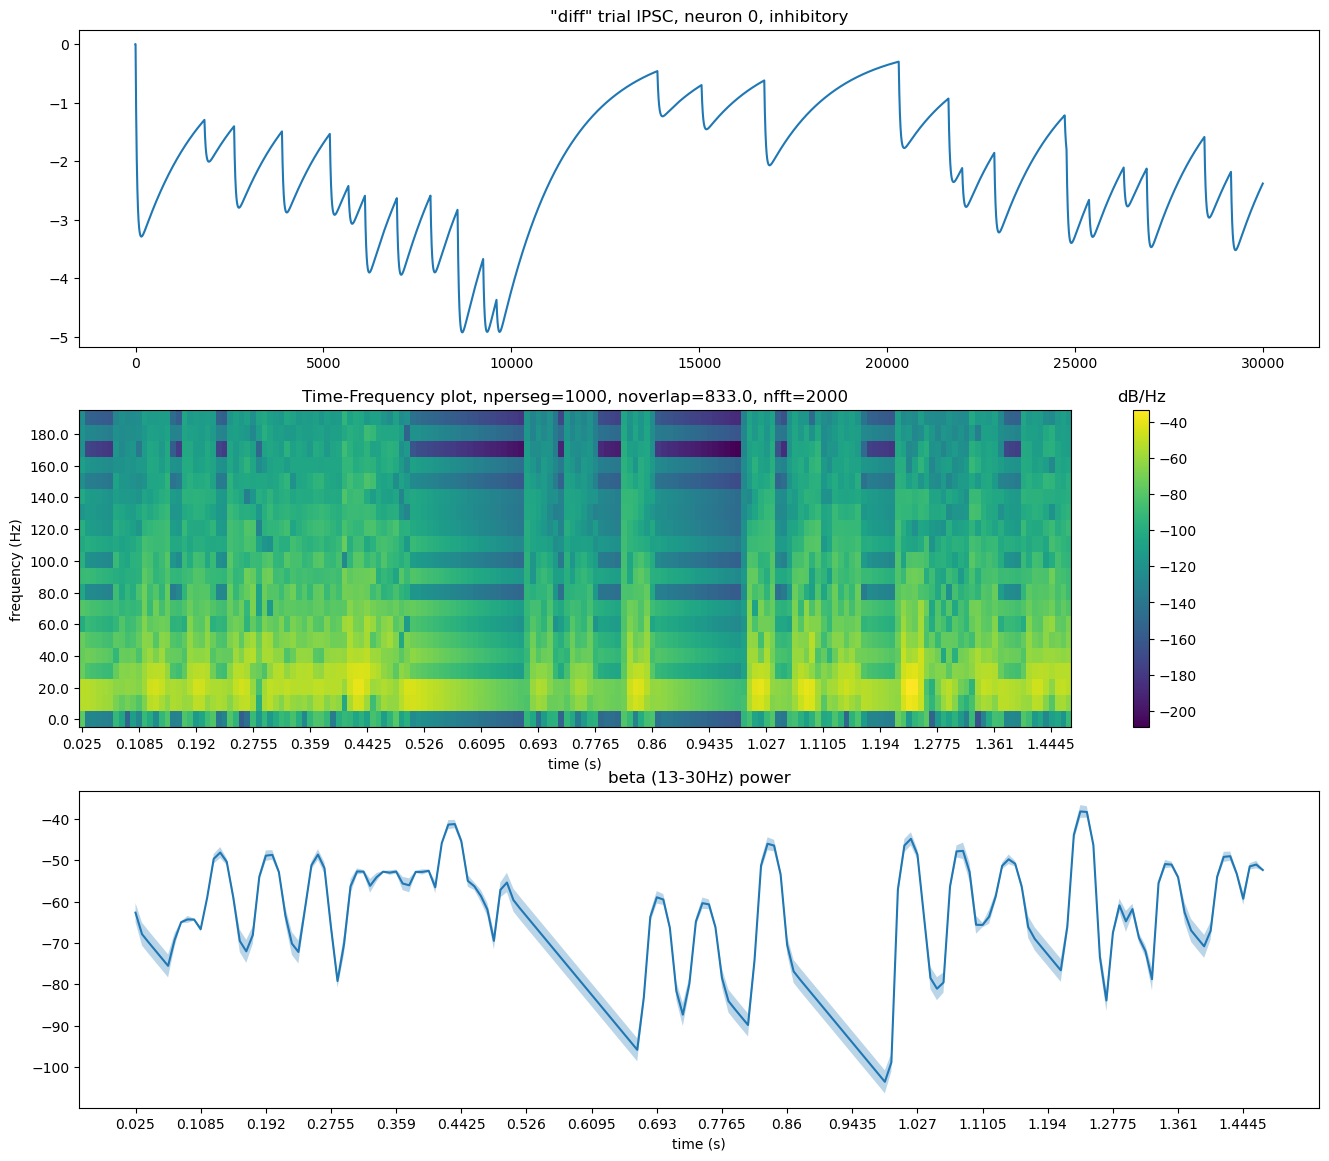

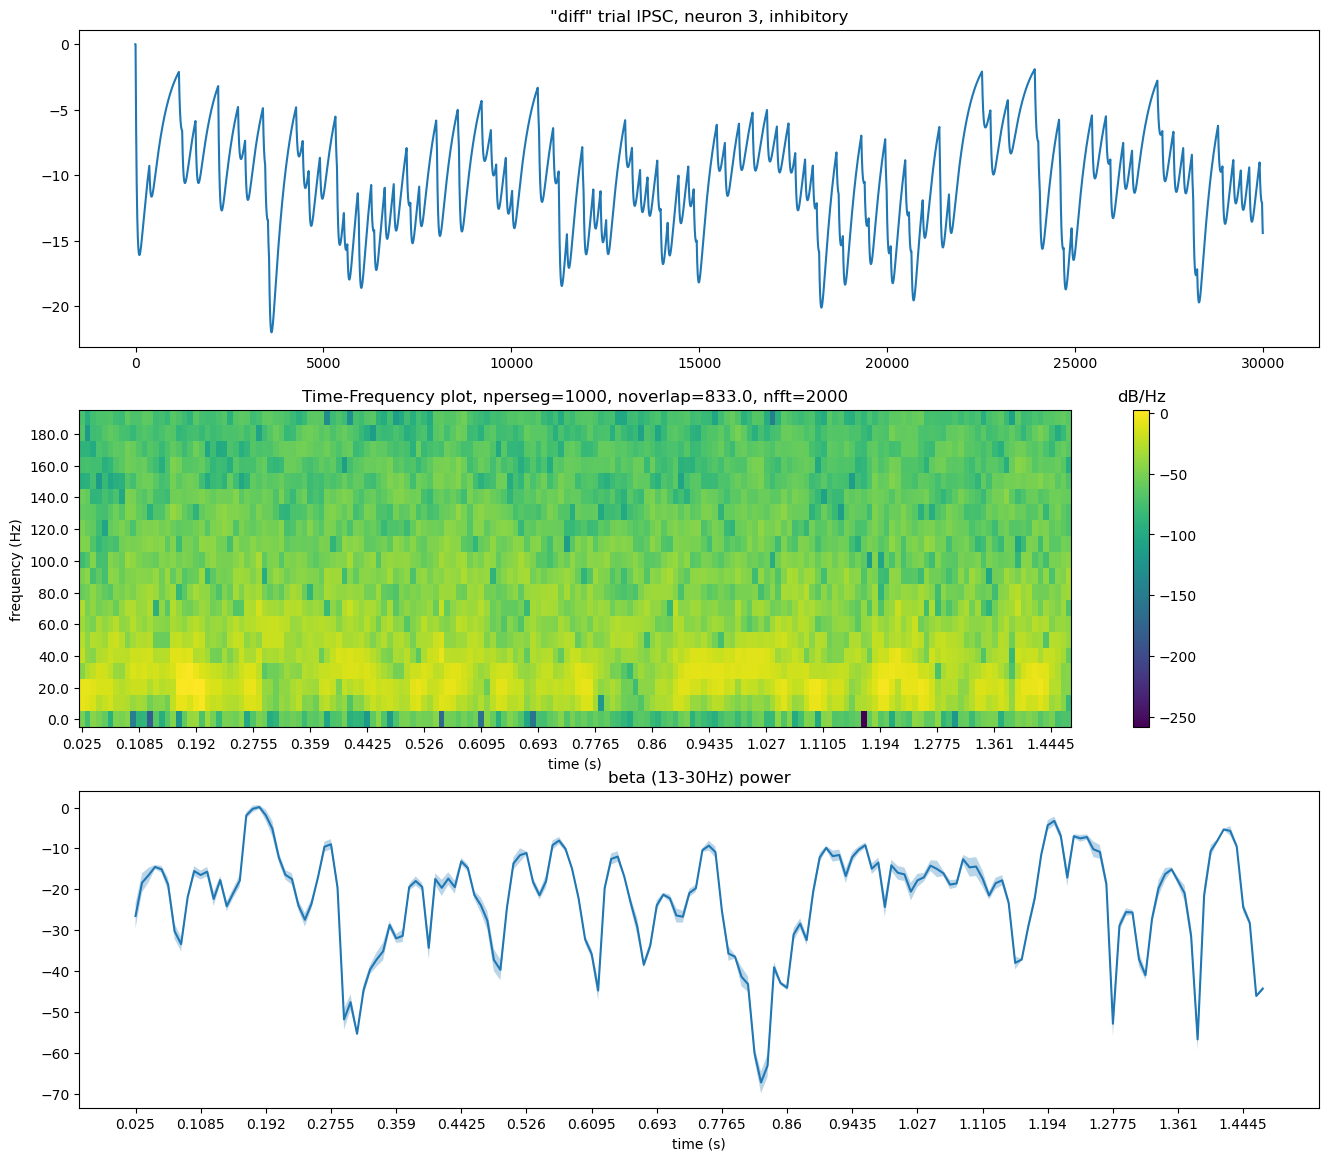

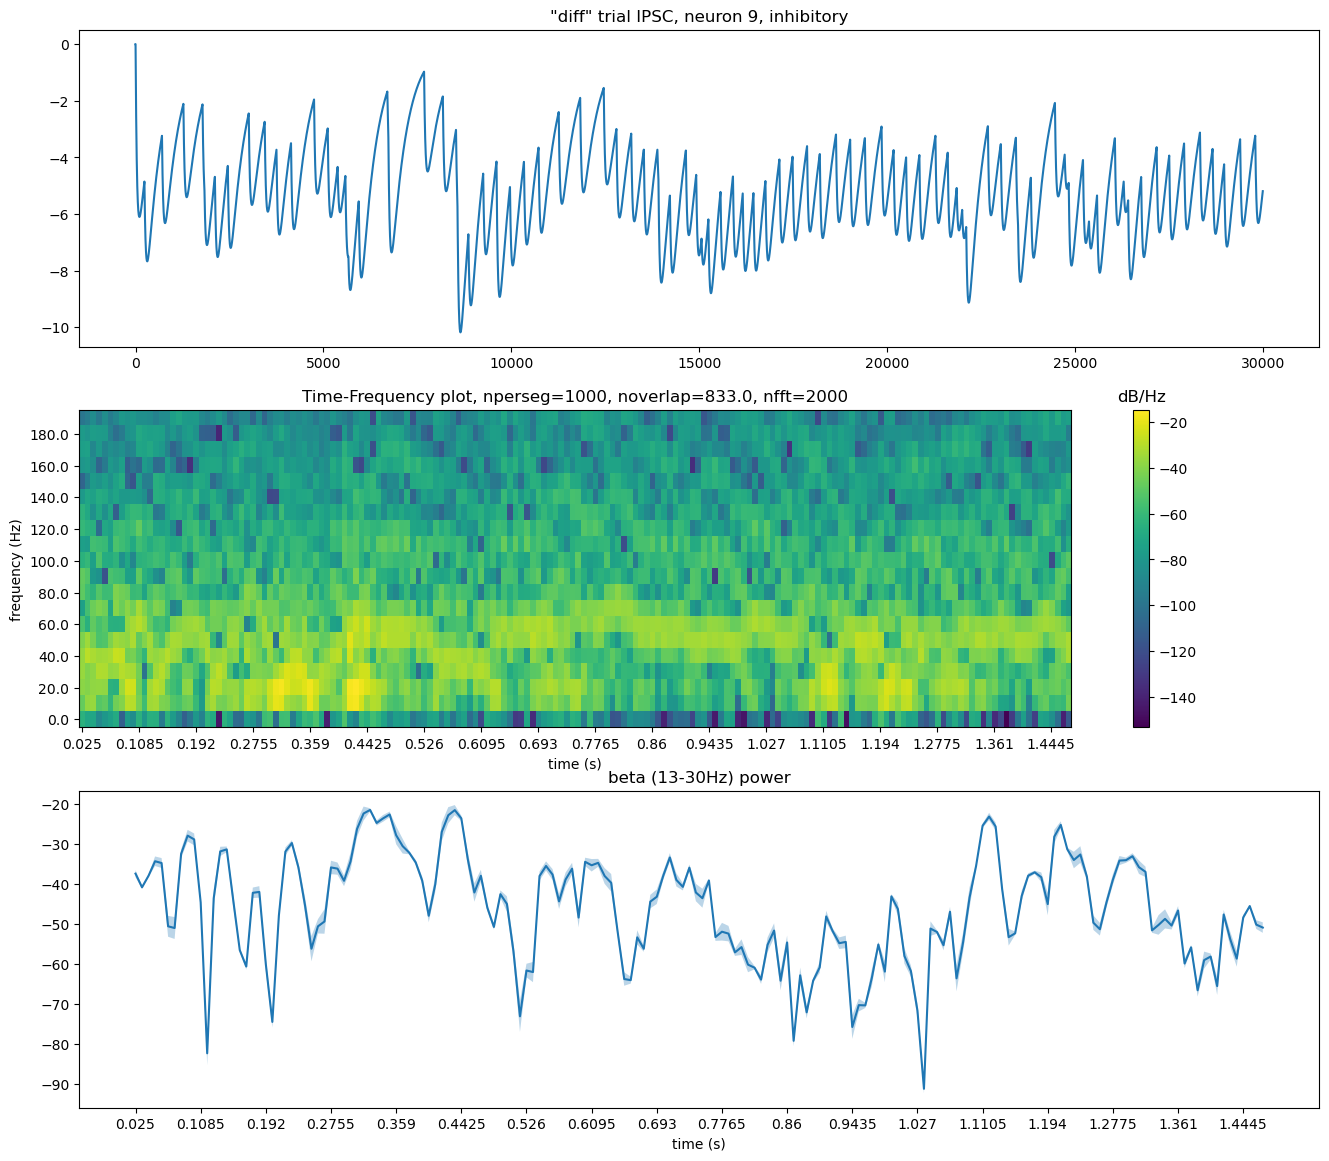

In [53]:
# plotting inhibitory

fs = 20000
nperseg=1000
noverlap = nperseg//1.2
nfft = nperseg*2
f_cutoff = 200

f, t, s = calc_spect(diff_IPSCs, fs=fs, nperseg=nperseg, 
                     noverlap=noverlap, nfft=nfft, f_cutoff=f_cutoff, 
                     plot=1, neuron_nums=inh_ind[:3], t_skip=10, f_skip=2, trial_label='diff')

### Phase-Amplitude Coupling

In [104]:
import tensorpac

In [105]:
ipsc_data = scipy.io.loadmat(os.path.join(model_dir, model_fname[:-4], 'diffIPSCs15.mat'))
ipsc_data.keys()

diff_IPSCs_15 = ipsc_data['diff_IPSCs']
print(diff_IPSCs_15.shape)

(200, 30000, 15)


https://etiennecmb.github.io/tensorpac/

#### Event-related PAC

first, get the data in the right format for the event-related PACs tutorial (https://etiennecmb.github.io/tensorpac/auto_examples/tuto/plot_real_data.html#sphx-glr-auto-examples-tuto-plot-real-data-py)
- data (n_trials, n_times)
- fs (sampling freq)
- times (range times)

In [116]:
fs = 20000
times = np.arange(diff_IPSCs_15.shape[1])
data = diff_IPSCs_15[0,:,:].T # 1 neuron, trials x times
n_trials = data.shape[0]
print(data.shape)

(15, 30000)


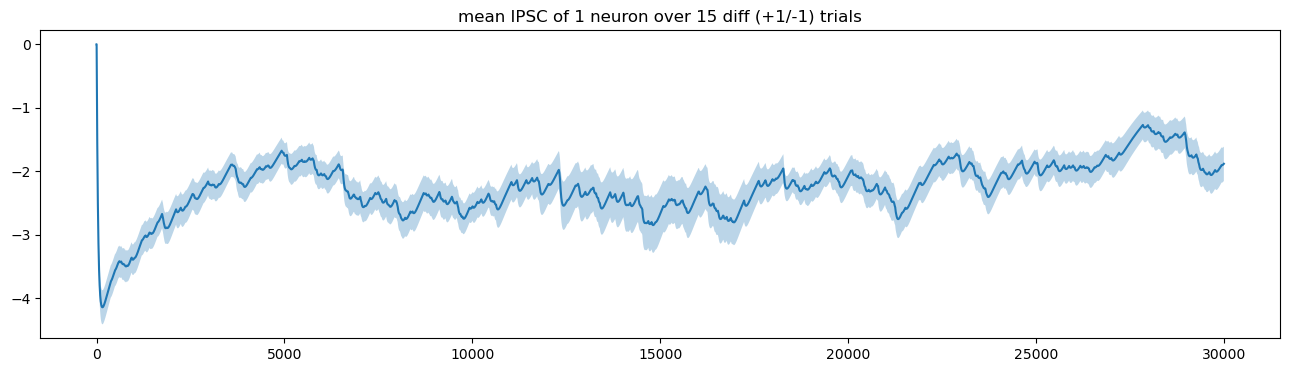

In [124]:
plt.figure(figsize=(16,4))
ipsc_mean = np.nanmean(data, axis=0)
ipsc_sem = np.sqrt(np.nanstd(data, axis=0))/np.sqrt(n_trials)
plt.plot(ipsc_mean)
plt.fill_between(times, ipsc_mean-ipsc_sem, ipsc_mean+ipsc_sem, alpha=0.3)
plt.title(f'mean IPSC of 1 neuron over {n_trials} diff (+1/-1) trials')
plt.show()

In [ ]:
from tensorpac import Pac, EventRelatedPac, PreferredPhase
from tensorpac.utils import PeakLockedTF, PSD, ITC, BinAmplitude

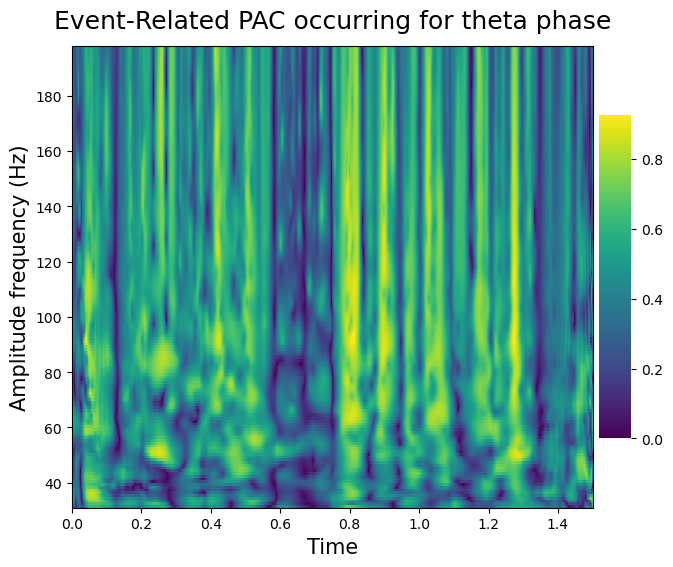

In [117]:
# following the params in the example
rp_obj = tensorpac.EventRelatedPac(f_pha=[4, 8], f_amp=(30, 200, 2, 1), dcomplex='hilbert', 
                         cycle=(3,6), width=7)
erpac = rp_obj.filterfit(fs, data, method='circular')

plt.figure(figsize=(8, 6))
rp_obj.pacplot(erpac.squeeze(), times/fs, rp_obj.yvec, xlabel='Time',
               ylabel='Amplitude frequency (Hz)',
               title='Event-Related PAC occurring for theta phase',
               fz_labels=15, fz_title=18)
plt.show()

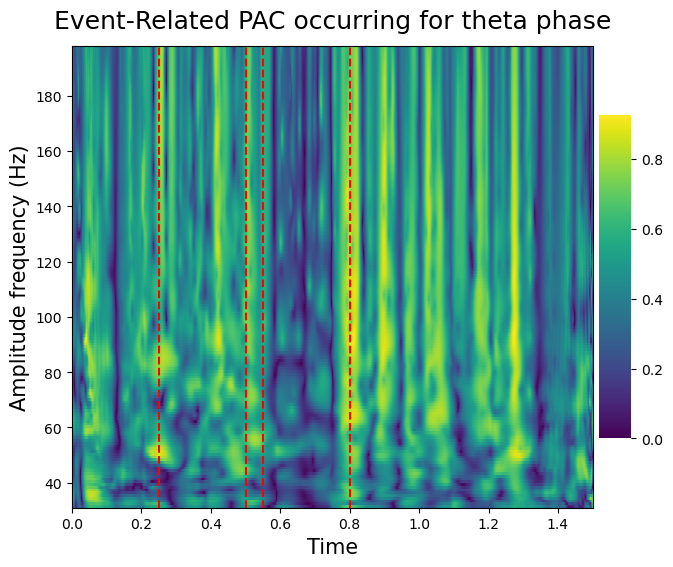

In [123]:
plt.figure(figsize=(8, 6))
rp_obj.pacplot(erpac.squeeze(), times/fs, rp_obj.yvec, xlabel='Time',
               ylabel='Amplitude frequency (Hz)',
               title='Event-Related PAC occurring for theta phase',
               fz_labels=15, fz_title=18)
plt.axvline(settings['stim_on']/fs*100, color='r', linestyle='--')
plt.axvline((settings['stim_on']+settings['stim_dur'])/fs*100, color='r', linestyle='--')
plt.axvline((settings['stim_on']+settings['stim_dur']+settings['delay'])/fs*100, color='r', linestyle='--')
plt.axvline((settings['stim_on']+2*settings['stim_dur']+settings['delay'])/fs*100, color='r', linestyle='--')
plt.show()

#### PACs (not event-related)

get the data in the right format
- data (n_times)  -- collapse the trial dimension
- fs (sampling freq)
- times (range times)

In [125]:
data.shape

(15, 30000)

In [126]:
data_flat = data.reshape((-1))
data_flat.shape

(450000,)

In [127]:
pac_obj = tensorpac.Pac(idpac=(2,1,0), f_pha=(2, 14, 2, 1), f_amp=(30, 200, 2, 1), dcomplex='hilbert',
                        cycle=(3, 6), width=7, n_bins=18)

pac = pac_obj.filterfit(fs, data_flat)

Phase Amplitude Coupling object defined
    extract phases (n_pha=10) and amplitudes (n_amps=168)


KeyboardInterrupt: 

In [115]:
pac.shape

(168, 10, 1)

WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


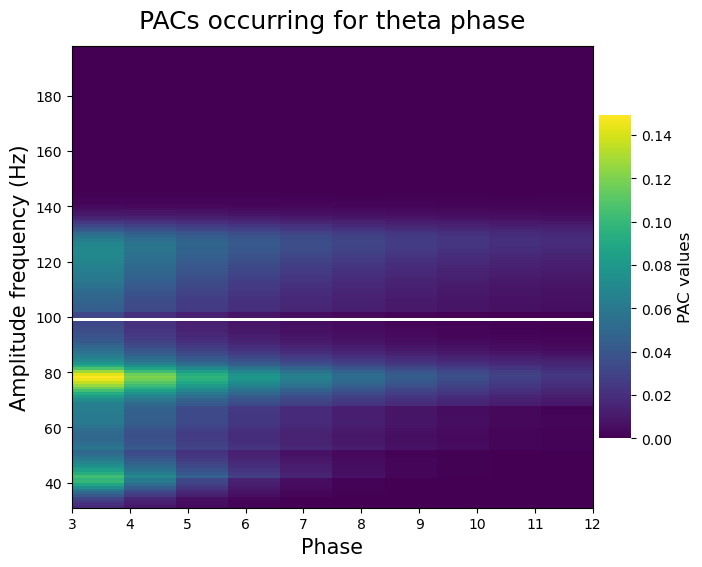

In [119]:
plt.figure(figsize=(8, 6))
pac_obj.comodulogram(pac, 
                     xlabel='Phase', ylabel='Amplitude frequency (Hz)',
                     title='PACs occurring for theta phase',
                     fz_labels=15, fz_title=18)
plt.show()

Try with z-scoring by surrogates

In [121]:
pac_obj = tensorpac.Pac(idpac=(2,1,4), f_pha=(2, 14, 2, 1), f_amp=(30, 200, 2, 1), dcomplex='hilbert',
                        cycle=(3, 6), width=7, n_bins=18)

pac = pac_obj.filterfit(fs, data_flat)

Phase Amplitude Coupling object defined
    extract phases (n_pha=10) and amplitudes (n_amps=168)
/Users/Renee/anaconda3/envs/rnn_test/lib/python3.11/site-packages/tensorpac/spectral.py:100: RuntimeWarning: invalid value encountered in scalar divide
  m = (o[s + 1] - o[s]) / (f[s + 1] - f[s])
    true PAC estimation using Modulation Index (MI, Tort et al. 2010)
    compute surrogates (Permute phase across trials (Tort et al. 2010), 200 permutations, random_state=7279)
python(76326) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76327) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76328) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76329) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76330) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76331) MallocStackLogging: can

In [122]:
pac.shape

(168, 10, 1)

WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


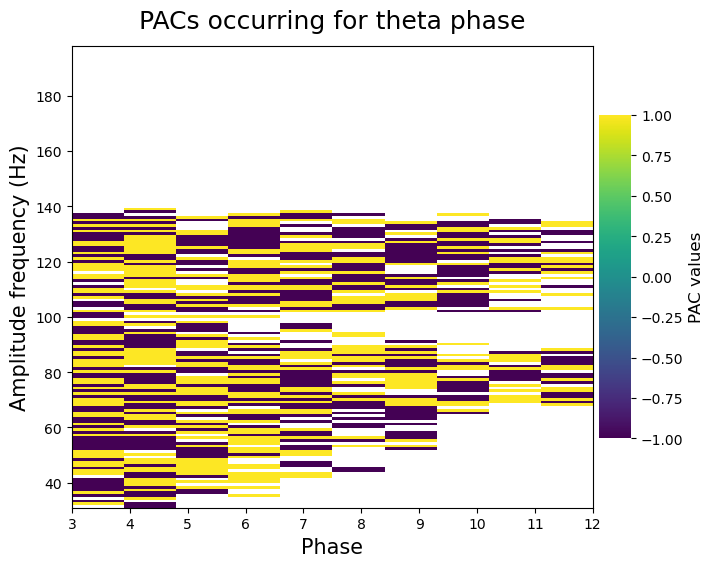

In [124]:
plt.figure(figsize=(8, 6))
pac_obj.comodulogram(pac, 
                     xlabel='Phase', ylabel='Amplitude frequency (Hz)',
                     title='PACs occurring for theta phase',
                     fz_labels=15, fz_title=18)
plt.show()

### Clustering neuron firing rates

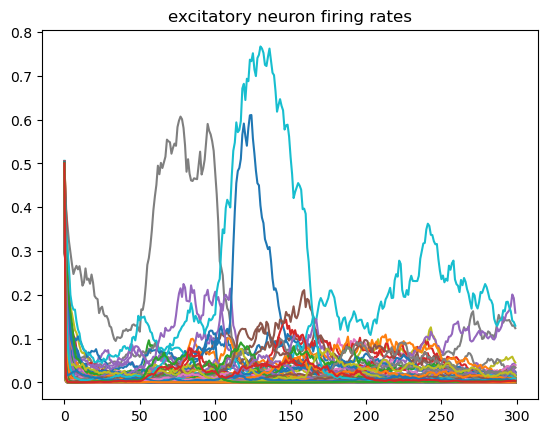

In [56]:
plt.plot(r[:,exc_ind])
plt.title('excitatory neuron firing rates')
plt.show()

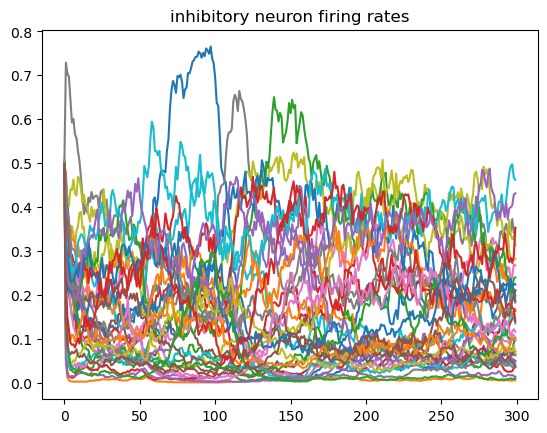

In [57]:
plt.plot(r[:,inh_ind])
plt.title('inhibitory neuron firing rates')
plt.show()

In [60]:
import sklearn.cluster

# cluster exc & inh separately
exc_labels = sklearn.cluster.KMeans(n_clusters=3).fit_predict(r[:,exc_ind].T) # x is samples by features
inh_labels = sklearn.cluster.KMeans(n_clusters=3).fit_predict(r[:,inh_ind].T) 

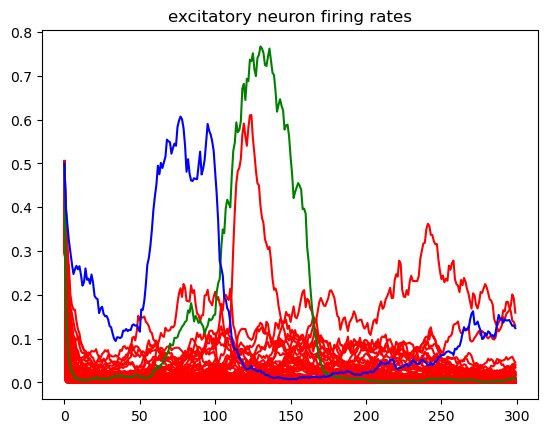

In [61]:
colors = ['r','g','b']
plt.figure()
for i in range(3):
    plt.plot(r[:,exc_ind[exc_labels == i]], c=colors[i])
plt.title('excitatory neuron firing rates')
plt.show()

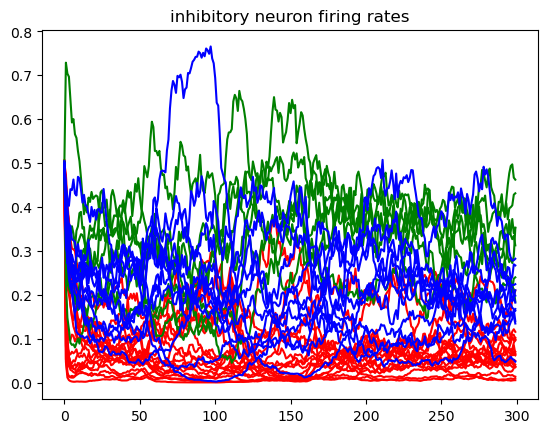

In [64]:
colors = ['r','g','b']
plt.figure()
for i in range(3):
    plt.plot(r[:,inh_ind[inh_labels == i]], c=colors[i])
plt.title('inhibitory neuron firing rates')
plt.show()

#### z-score

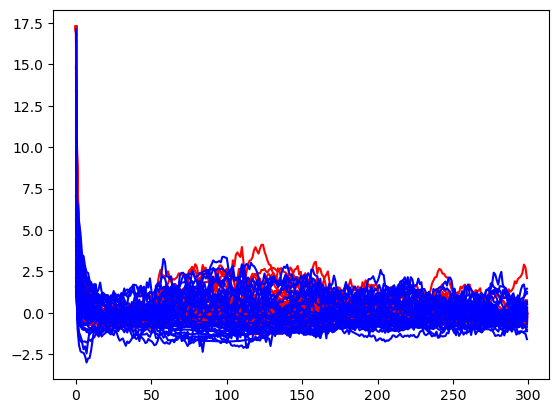

In [67]:
excz = scipy.stats.zscore(r[:,exc_ind], axis=0)
inhz = scipy.stats.zscore(r[:,inh_ind], axis=0)
plt.figure()
plt.plot(excz, c='r')
plt.plot(inhz, c='b')
plt.show()

In [68]:
import sklearn.cluster

# cluster exc & inh separately
exc_labels = sklearn.cluster.KMeans(n_clusters=3).fit_predict(excz.T) # x is samples by features
inh_labels = sklearn.cluster.KMeans(n_clusters=3).fit_predict(inhz.T) 

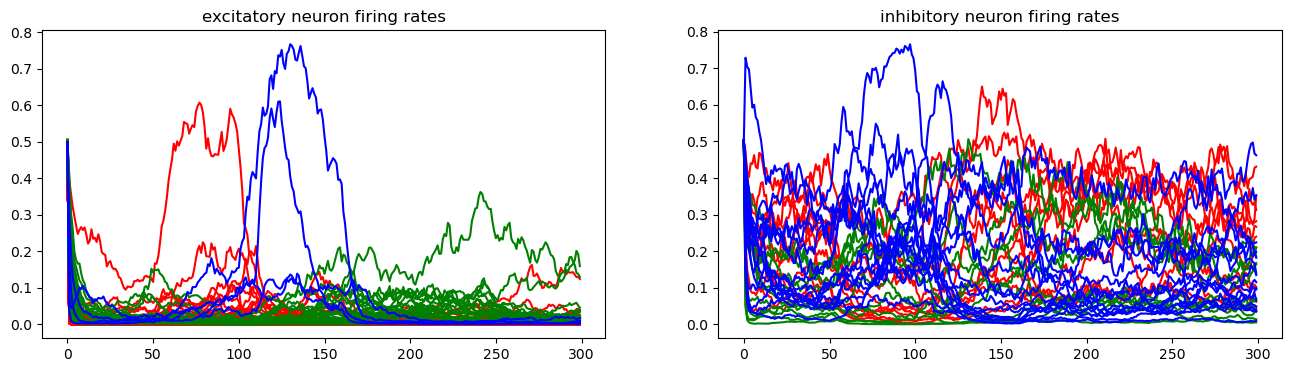

In [71]:
colors = ['r','g','b']
fig, axs = plt.subplots(1,2, figsize=(16,4))
for i in range(3):
    axs[0].plot(r[:,exc_ind[exc_labels == i]], c=colors[i])
    axs[1].plot(r[:,inh_ind[inh_labels == i]], c=colors[i])
axs[0].set_title('excitatory neuron firing rates')
axs[1].set_title('inhibitory neuron firing rates')
plt.show()

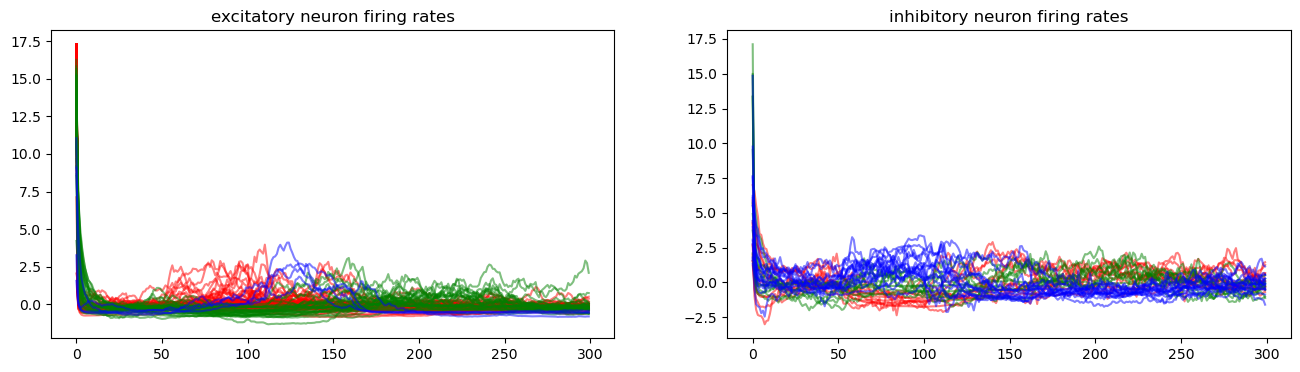

In [75]:
colors = ['r','g','b']
fig, axs = plt.subplots(1,2, figsize=(16,4))
for i in range(3):
    axs[0].plot(excz[:,exc_labels == i], c=colors[i], alpha=0.5)
    axs[1].plot(inhz[:,inh_labels == i], c=colors[i], alpha=0.5)
axs[0].set_title('excitatory neuron firing rates')
axs[1].set_title('inhibitory neuron firing rates')
# axs[0].set_ylim([-2,2])
# axs[1].set_ylim([-2,2])
plt.show()